In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
from matplotlib import colors, ticker

import pandas as pd
import numpy as np
import scipy as sp
from astropy.table import Table
import astropy.units as u
import astropy.coordinates as coord
import arviz as az
import seaborn as sns

import kinesis as kn
import gapipes as gp

plt.style.use('kinesis.mplstyle')

In [3]:
out_full = pd.read_csv("../data/hyades_full.csv")
# %store -r out_full
df = out_full.loc[out_full['in_dr2'] == True]
print(f'{len(df)} rows')

515 rows


In [4]:
necessary_columns = [
    "ra",
    "dec",
    "phot_g_mean_mag",
    "parallax",
    "pmra",
    "pmdec",
    "parallax_error",
    "pmra_error",
    "pmdec_error",
    "parallax_pmra_corr",
    "parallax_pmdec_corr",
    "pmra_pmdec_corr",
]

df_cleaned = df[necessary_columns + ["radial_velocity", "radial_velocity_error"]]

In [5]:
mm = kn.MixtureModel(recompile=True)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_653c13e2d47f997d6a3bcfc789ae23d1 NOW.
INFO:kinesis.models:Compiling mixture


In [6]:
b0 = np.median(df_cleaned.g.icrs.cartesian.xyz.value, axis=1)
print(f"b0 = {b0}")

def init():
    return {
        'd':1e3 / df["parallax"].values,
        'sigv':0.3,
        'v0':[-6.3,45,5],
        'v0_bg':[0,0,0],
        'lambda':0.1,
        'sigv_bg':50,
        'T':np.zeros(shape=(int(1), 3,3))
    }


stanfit = mm.fit(df_cleaned, b0=b0, init=init)

b0 = [17.26821532 41.64304963 13.606407  ]


In [7]:
azfit = az.from_pystan(stanfit)

In [8]:
az.summary(azfit)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
v0[0],-6.078,0.024,-6.123,-6.035,0.001,0.000,2071.0,2071.0,2069.0,2788.0,1.0
v0[1],45.673,0.042,45.594,45.751,0.001,0.001,1785.0,1785.0,1774.0,2724.0,1.0
v0[2],5.540,0.021,5.499,5.580,0.000,0.000,2179.0,2179.0,2183.0,2496.0,1.0
sigv,0.381,0.009,0.364,0.400,0.000,0.000,2728.0,2717.0,2754.0,2560.0,1.0
lambda,0.991,0.004,0.983,0.998,0.000,0.000,2824.0,2813.0,2158.0,1902.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
"T_param[1,1]",16.431,7.329,1.715,29.474,0.182,0.129,1623.0,1623.0,1617.0,2461.0,1.0
"T_param[1,2]",8.543,9.380,-8.239,26.599,0.215,0.152,1911.0,1911.0,1919.0,2473.0,1.0
"T_param[2,0]",8.779,6.278,-2.541,20.689,0.150,0.106,1755.0,1755.0,1757.0,2805.0,1.0
"T_param[2,1]",14.882,3.758,7.805,21.871,0.088,0.063,1815.0,1801.0,1813.0,2848.0,1.0


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f8eac068668>,
      dtype=object)

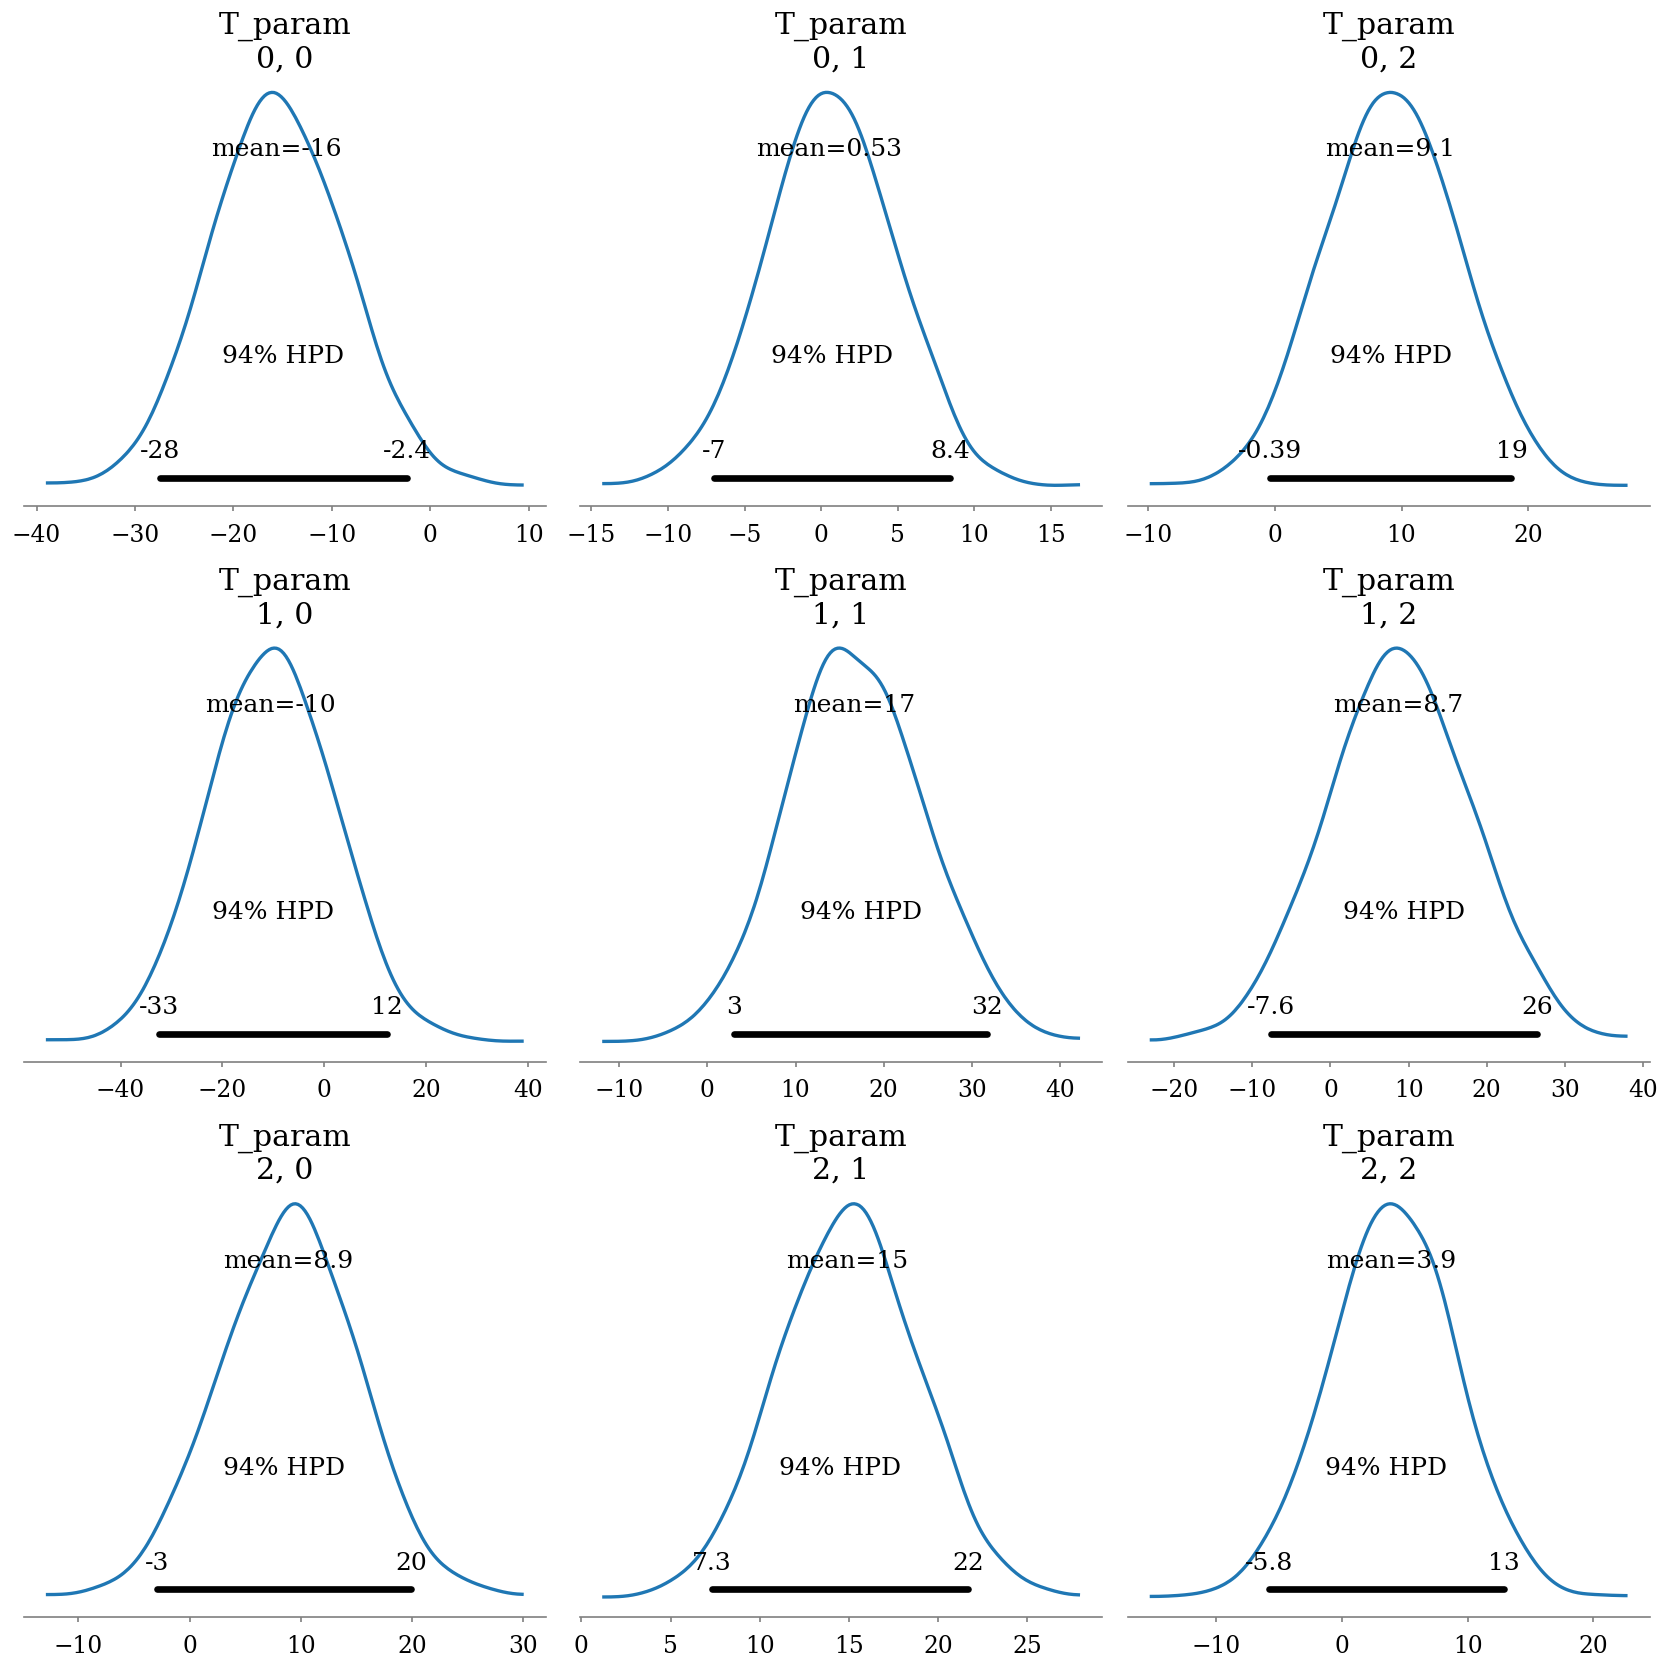

In [30]:
az.plot_posterior(azfit, var_names=['T_param'])

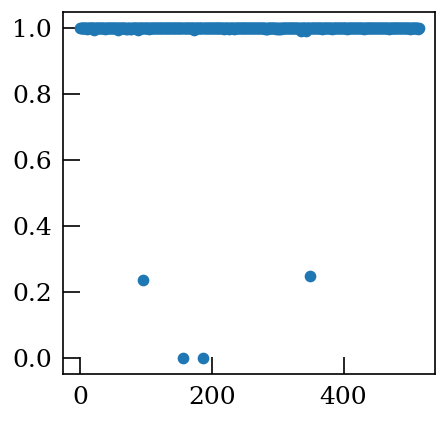

In [9]:
probmem = np.exp(stanfit['probmem'])
plt.plot(probmem.mean(axis=0), marker='o', ls='')

In [23]:
outlier = probmem.mean(axis=0)<0.5

In [24]:
df_cleaned.loc[outlier]

,ra,dec,phot_g_mean_mag,parallax,pmra,pmdec,parallax_error,pmra_error,pmdec_error,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,radial_velocity,radial_velocity_error
96,71.906946,18.258583,8.339932,20.756083,84.653427,-38.326308,0.078377,0.153508,0.073997,0.239290,0.250246,-0.460029,43.581905,0.257436
156,72.955280,17.273603,10.852497,18.357212,76.676365,-30.088681,0.051886,0.095150,0.049673,0.117610,0.336112,-0.340585,38.494854,0.338139
187,78.714192,17.787029,13.499721,17.602923,54.276757,-27.363508,0.053941,0.081767,0.062659,0.306982,0.412306,0.060959,16.515485,2.967589
349,69.000751,16.540674,10.292080,19.126738,97.046816,-23.890458,0.427356,0.863665,0.657480,0.292345,0.043364,-0.242555,44.785935,0.917492


Text(0.5, 0, '${\\rm m}\\,{\\rm s}^{-1}\\,{\\rm pc}^{-1}$')

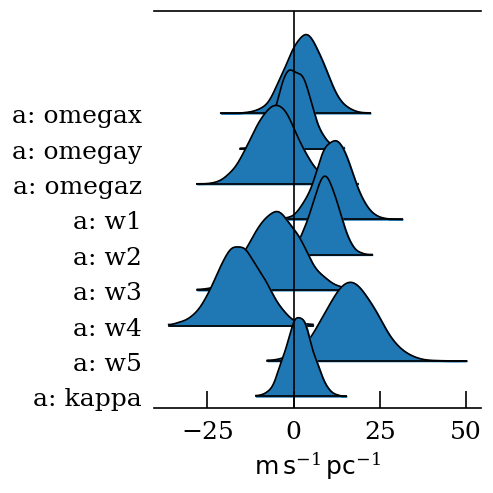

In [29]:
names = ["omegax", "omegay", "omegaz", "w1", "w2", "w3", "w4", "w5", "kappa"]

for k,v in kn.decompose_T(azfit.posterior.T_param).items():
    azfit.posterior[k] = v

fig, ax = az.plot_forest(
    [azfit],
    kind="ridgeplot",
    var_names=names,
    combined=True,
    ridgeplot_overlap=3,
    figsize=(4, 4),
    linewidth=1,
    model_names=['a'],
)
ax[0].axvline(0, c="k", lw=1)
ax[0].set_xlabel(r"${\rm m}\,{\rm s}^{-1}\,{\rm pc}^{-1}$")

In [34]:
T_galactic = kn.rotate_T_to_galactic(stanfit["T_param"])
# T_galactic = stanfit["T_param"]
T_sym = (T_galactic + np.transpose(T_galactic, (0, 2, 1))) / 2.
T_antisym = (T_galactic - np.transpose(T_galactic, (0, 2, 1))) / 2.

In [35]:
# math check
assert (
    (T_antisym[:, 2, 1] == kn.decompose_T(T_galactic)["omegax"]).all(),
    (T_antisym[:, 0, 2] == kn.decompose_T(T_galactic)["omegay"]).all(),
    (T_antisym[:, 1, 0] == kn.decompose_T(T_galactic)["omegaz"]).all(),
) == (True, True, True)

In [36]:
# decompose and sort by eigenvalues
w, v = np.linalg.eig(T_sym)

i_wsort = np.argsort(w, axis=1)
# my numpy-fu running out...
sorted_v = np.stack([v[j][:,i] for j, i in enumerate(i_wsort)])
sorted_w = np.sort(w, axis=1)

# verify math
assert np.allclose(sorted_w.mean(axis=1), kn.decompose_T(T_galactic)["kappa"]) == True

In [37]:
# sorted_v[:,:,0] *= np.sign(sorted_v[:,2,0])[:,None]
# sorted_v[:,:,1] *= np.sign(sorted_v[:,2,1])[:,None]
# sorted_v[:,:,2] *= np.sign(sorted_v[:,2,2])[:,None]

 -23.172 +-    7.227 (   3.206)-0.01393, -0.01371,  0.26474
   2.291 +-    3.991 (   0.574)-0.04720, -0.25944,  0.04947
  25.602 +-    7.083 (   3.615) 0.64119, -0.01318, -0.00748


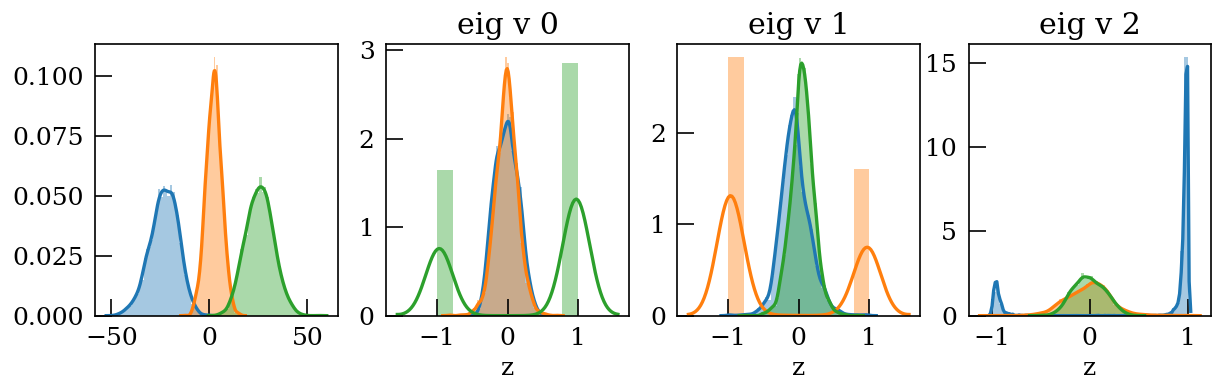

In [38]:
fig, ax = plt.subplots(1, 4, figsize=(12, 3))
sns.distplot(sorted_w.T[0], ax=ax[0])
sns.distplot(sorted_w.T[1], ax=ax[0])
sns.distplot(sorted_w.T[2], ax=ax[0]);

for i in range(3):
    vd = pd.DataFrame(sorted_v[:,:,i], columns=['x','y','z'])
    for col in vd:
        sns.distplot(vd[col], ax=ax[i+1])#, legend=False)
    ax[i+1].set_title(f"eig v {i}")

for i, cw in enumerate(sorted_w.T):
    print(f"{np.mean(cw):8.3f} +- {np.std(cw):8.3f} ({np.abs(np.mean(cw)/np.std(cw)):8.3f})", end='')
    print(f"{np.mean(sorted_v[:,0,i]):-8.5f}, {np.mean(sorted_v[:,1,i]):-8.5f}, {np.mean(sorted_v[:,2,i]):-8.5f}")

In [26]:
df_cleaned.loc[outlier].g.icrs.velocity.d_xyz.value

array([[ -4.67284814,  -7.47989649, -10.81592238,  -6.46590811],
       [ 47.95241152,  43.15378379,  20.49002395,  50.27438275],
       [  5.34186137,   4.01096733,  -1.97160308,   7.07426739]])

In [19]:
dvabs = (vx-np.nanmean(vx))**2 + (vy-np.nanmean(vy))**2+(vx-np.nanmean(vz))**2

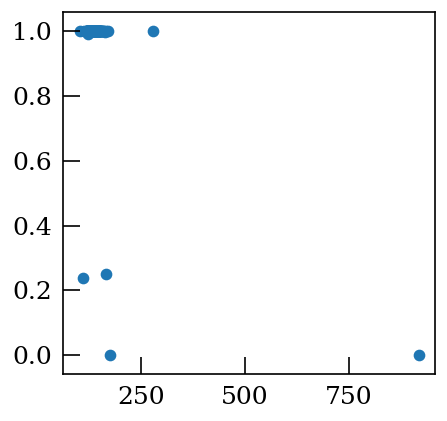

In [20]:
vx,vy,vz= df_cleaned.g.icrs.velocity.d_xyz.value
plt.scatter(dvabs, probmem.mean(axis=0));

In [6]:
model = kn.get_model("mixture", recompile=False)

rv = np.empty(0, float)
rv_error = np.empty(0, float)
irv = np.empty(0, int)
Nrv = 0

data = dict(
    N=len(df_cleaned),
    ra=df_cleaned["ra"].values,
    dec=df_cleaned["dec"].values,
    a=df_cleaned[["parallax", "pmra", "pmdec"]].values,
    C=df_cleaned.g.make_cov(),
    irv = np.arange(N)[df_cleaned["radial_velocity"].notna()],
    rv = df_cleaned["radial_velocity"].values[irv],
    rv_error = df_cleaned["radial_velocity_error"].values[irv],
    Nrv = df_cleaned["radial_velocity"].notna().sum(),
    include_T=0,
    theta=[0.5,0.5],
    b0=b0
)

# TODO: init with MAP
def init():
    return {
        'd':1e3 / df["parallax"].values,
        'sigv':1.5,
        'v0':[-6.3,45,5],
        'v0_bg':[0,0,0],
        'lambda':0.1,
        'sigv_bg':50,
        'T':np.zeros(shape=(int(0), 3,3))
    }


fit = model.optimizing(data=data, init=init)

INFO:kinesis.models:Reading model from disk


b0 = [17.26821532 41.64304963 13.606407  ]


In [7]:
optfit = m.fit(data, sample=False)

INFO:numexpr.utils:Note: detected 88 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 88 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [8]:
optfit['v0'], optfit['sigv']

(array([-6.06871844, 45.66619862,  5.53867883]), array(0.38673098))

In [9]:
vxyz = df.loc[df.radial_velocity.notnull()].g.icrs.velocity.d_xyz.value

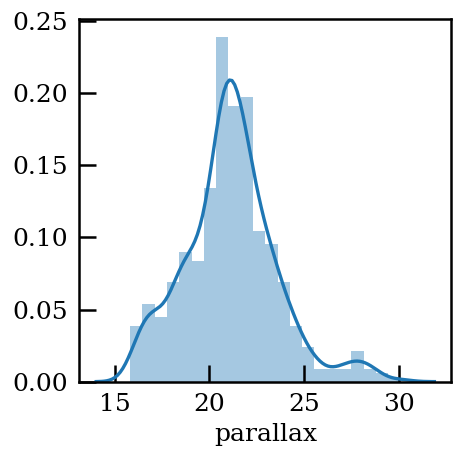

In [10]:
sns.distplot(df['parallax'], );

In [11]:
for i in range(3):
    print(np.sum(np.abs(vxyz[i]-np.median(vxyz[i]))/np.std(vxyz[i]) > 3))

3
2
1


(-25, 25)

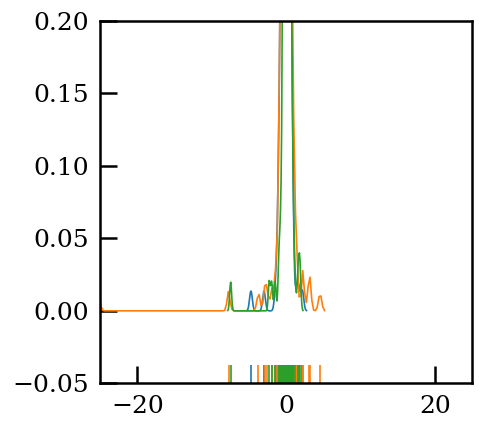

In [14]:
sns.distplot(vxyz[0]-np.median(vxyz[0]), hist=False, kde_kws={'lw':1}, rug=True)
sns.distplot(vxyz[1]-np.median(vxyz[1]), hist=False, kde_kws={'lw':1}, rug=True)
sns.distplot(vxyz[2]-np.median(vxyz[2]), hist=False, kde_kws={'lw':1}, rug=True);
plt.ylim(-0.05, 0.2);
plt.xlim(-25,25)

In [15]:
model = kn.get_model("mixture")

N = len(df)
irv = np.arange(N)[df["radial_velocity"].notna()]
rv = df["radial_velocity"].values[irv]
rv_error = df["radial_velocity_error"].values[irv]
Nrv = len(irv)
include_T = 1
data = dict(
    N=len(df),
    ra=df["ra"].values,
    dec=df["dec"].values,
    a=df[["parallax", "pmra", "pmdec"]].values,
    C=df.g.make_cov(),
    rv=rv,
    rv_error=rv_error,
    irv=irv,
    Nrv=Nrv,
    include_T=include_T,
    theta=[0.5,0.5]
)

data["b0"] = b0


def init():
    return dict(
        d=1e3 / df["parallax"].values,
        sigv=0.1,
#         v0=np.random.normal(scale=50, size=3),
        v0=[-6.3, 45, 5],
        T=np.zeros(shape=(int(include_T), 3, 3)),
        # rv_offset=0.0,
        # rv_extra_dispersion=0.1,
    )

fit = model.optimizing(data=data, init=init)

INFO:kinesis.models:Reading model from disk


In [16]:
fit['v0'], fit['sigv'], fit['theta'], fit['T_param']

(array([-6.07474198, 45.66703136,  5.53629498]),
 array(0.38142826),
 array([1.00000000e+00, 1.09203979e-10]),
 array([[-13.49824669,  -3.03450704,   7.42076859],
        [ -3.68532654,   7.71472831,   0.79799803],
        [ 14.25624172,  14.09437752,   3.60673744]]))

In [17]:
kn.decompose_T(fit['T_param'])

{'omegax': 6.648189744084263,
 'omegay': -3.417736564466888,
 'omegaz': -0.32540974928199407,
 'w1': 7.446187773957561,
 'w2': 10.838505153239183,
 'w3': -3.3599167936976553,
 'w4': array(-13.49824669),
 'w5': array(7.71472831),
 'kappa': -0.7255936485245877}

In [26]:
%%time
fit2 = model.sampling(data, init=init, pars=['v0','sigv','theta', 'T_param'])

CPU times: user 1.84 s, sys: 2.17 s, total: 4 s
Wall time: 6min 24s


In [27]:
azfit = az.from_pystan(fit2)

In [29]:
az.summary(azfit, var_names=['v0','sigv','theta', 'T_param'])

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
v0[0],-6.083,0.023,-6.124,-6.039,0.002,0.001,203.0,203.0,191.0,587.0,1.04
v0[1],45.656,0.036,45.592,45.728,0.004,0.003,87.0,87.0,80.0,705.0,1.05
v0[2],5.534,0.020,5.499,5.574,0.001,0.001,209.0,209.0,209.0,671.0,1.02
sigv,0.394,0.008,0.378,0.411,0.000,0.000,365.0,365.0,362.0,654.0,1.01
theta[0],0.996,0.003,0.992,1.000,0.001,0.000,16.0,15.0,13.0,33.0,1.24
theta[1],0.004,0.003,0.000,0.008,0.001,0.000,16.0,16.0,13.0,33.0,1.24
"T_param[0,0]",-13.545,6.977,-26.865,-2.192,1.532,1.099,21.0,21.0,22.0,103.0,1.15
"T_param[0,1]",-2.366,4.896,-12.644,5.104,1.483,1.120,11.0,10.0,12.0,28.0,1.26
"T_param[0,2]",7.155,5.333,-2.043,16.821,1.402,1.049,14.0,14.0,16.0,163.0,1.19
"T_param[1,0]",-5.142,11.224,-25.891,14.148,3.474,2.528,10.0,10.0,12.0,64.0,1.27


In [32]:
fit2['sigv']

array([2.32765478, 2.32976248, 2.33525305, ..., 2.40849291, 2.39987707,
       2.39728543])

In [29]:
np.mean(fit2['v0'],axis=0),

array([-6.22523394, 44.84792182,  5.04733873])

In [15]:
az.summary(fit.azfit, var_names=['v0', 'sigv'])

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
v0[0],-5.939,0.373,-6.643,-5.283,0.005,0.004,5148.0,5146.0,5152.0,3415.0,1.0
v0[1],45.667,0.453,44.822,46.506,0.006,0.005,4887.0,4886.0,4858.0,2993.0,1.0
v0[2],5.335,0.355,4.708,6.028,0.005,0.004,4953.0,4953.0,4951.0,3267.0,1.0
sigv,3.543,0.164,3.246,3.844,0.002,0.002,5239.0,5164.0,5301.0,2654.0,1.0


3.1395833788613317

In [13]:
az.fit.azfit

In [167]:
dims = {
    "v0": ["axis"],
    "a_hat": ["star", "axis"],
    "log_likelihood": ["star"],
    "a": ["star", "axis"],
    'T_param': ['v_axis', 'axis']
}
coords = {"axis": ["x", "y", "z"]}
azkwargs = {
    "coords": coords,
    "dims": dims,
    "log_likelihood": "log_lik_a",
    "posterior_predictive": ["a_hat", "rv_hat"],
    "observed_data": ["a", "rv"],
}
azfit = az.from_pystan(stanfit, **azkwargs)

In [6]:
stanfit = kn.load_stanfit("test_save_model_fit.pkl")
azfit = az.from_pystan(stanfit)

In [23]:
rv_res = m.calculate_rv_residual(fit2)

# outliers by 3-sigma
bool_rv_outliers = np.abs(rv_res.mean(axis=0))>3
idx_rv_outliers = stanfit.data['irv'][bool_rv_outliers]
print(bool_rv_outliers.sum())
print("index of outliers in original df :", idx_rv_outliers)

ValueError: No parameter rv_model

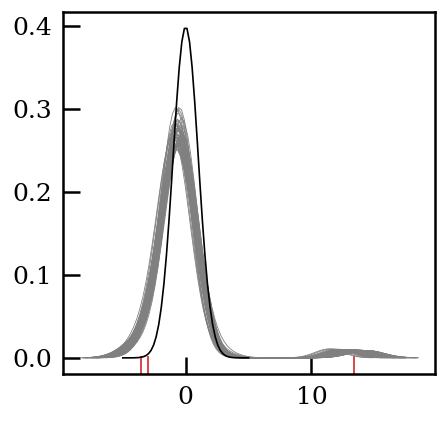

In [10]:
for i in np.random.choice(rv_res.shape[0], size=50):
    sns.distplot(rv_res[i], hist=False, kde_kws={'lw':.5, 'color':'gray'})
x=np.linspace(-5,5)
plt.plot(x, sp.stats.norm.pdf(x), 'k-', lw=1);
# highlight outliers
sns.rugplot(rv_res.mean(axis=0)[bool_rv_outliers], color='tab:red');

In [37]:
import seaborn as sns

In [178]:
np.std(col)

<xarray.DataArray 'a_hat' ()>
array(0.102431)
Coordinates:
    star     int64 0
    axis     <U1 'x'

In [177]:
np.sqrt(stanfit.data['C'][0,0,0])

0.07269225997312176

In [ ]:
az

In [173]:
stanfit.data['C'][0,0,0]

0.00528416465999992

In [174]:
stanfit.data['a'][0]

array([ 20.90476755, 109.07619543, -38.85147984])

In [ ]:
azfit.poster

array([5.94506289e-127, 8.50519137e-130, 1.13159153e-132, 1.40014577e-135,
       1.61114555e-138, 1.72414689e-141, 1.71589897e-144, 1.58813394e-147,
       1.36697478e-150, 1.09423812e-153, 8.14593872e-157, 5.63960129e-160,
       3.63106169e-163, 2.17418660e-166, 1.21070397e-169, 6.26984896e-173,
       3.01963294e-176, 1.35247483e-179, 5.63355052e-183, 2.18229349e-186,
       7.86180166e-190, 2.63395876e-193, 8.20679949e-197, 2.37802621e-200,
       6.40822000e-204, 1.60596528e-207, 3.74293990e-211, 8.11273925e-215,
       1.63531020e-218, 3.06556645e-222, 5.34440407e-226, 8.66494480e-230,
       1.30650260e-233, 1.83203057e-237, 2.38909335e-241, 2.89742020e-245,
       3.26789287e-249, 3.42769445e-253, 3.34360029e-257, 3.03322460e-261,
       2.55901450e-265, 2.00779277e-269, 1.46501810e-273, 9.94134294e-278,
       6.27371930e-282, 3.68199398e-286, 2.00964352e-290, 1.02007697e-294,
       4.81531632e-299, 2.11394976e-303])

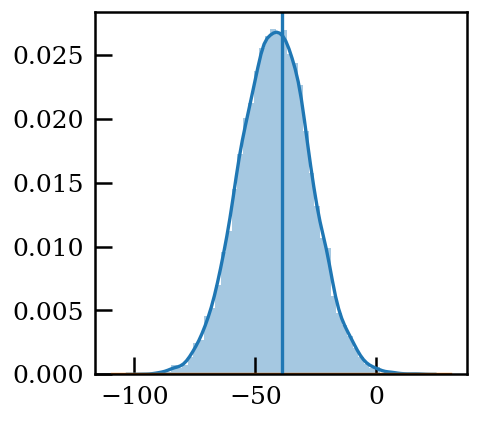

In [191]:
i =0
j=2
col = azfit.posterior_predictive['a_hat'][:,:,i,j]
sns.distplot(col.values.ravel())
x = np.linspace(*plt.gca().get_xlim())

px = sp.stats.norm.pdf(
    x,
    loc=azfit.observed_data["a"][i, j].values,
    scale=np.sqrt(stanfit.data["C"][i, j, j]),
)
plt.plot(x, px)
plt.axvline(azfit.observed_data["a"][i, j].values,)

In [57]:
azfit.posterior_predictive

<xarray.Dataset>
Dimensions:       (axis: 3, chain: 6, draw: 2000, rv_hat_dim_0: 33, star: 111)
Coordinates:
  * chain         (chain) int64 0 1 2 3 4 5
  * draw          (draw) int64 0 1 2 3 4 5 6 ... 1994 1995 1996 1997 1998 1999
  * star          (star) int64 0 1 2 3 4 5 6 7 ... 104 105 106 107 108 109 110
  * axis          (axis) <U1 'x' 'y' 'z'
  * rv_hat_dim_0  (rv_hat_dim_0) int64 0 1 2 3 4 5 6 7 ... 26 27 28 29 30 31 32
Data variables:
    a_hat         (chain, draw, star, axis) float64 20.79 99.58 ... 106.0 36.12
    rv_hat        (chain, draw, rv_hat_dim_0) float64 39.35 35.55 ... -25.57
Attributes:
    created_at:                 2019-08-30T13:25:09.569450
    inference_library:          pystan
    inference_library_version:  2.18.0.0

In [67]:
azfit.posterior_predictive

<xarray.Dataset>
Dimensions:       (axis: 3, chain: 6, draw: 2000, rv_hat_dim_0: 33, star: 111)
Coordinates:
  * chain         (chain) int64 0 1 2 3 4 5
  * draw          (draw) int64 0 1 2 3 4 5 6 ... 1994 1995 1996 1997 1998 1999
  * star          (star) int64 0 1 2 3 4 5 6 7 ... 104 105 106 107 108 109 110
  * axis          (axis) <U1 'x' 'y' 'z'
  * rv_hat_dim_0  (rv_hat_dim_0) int64 0 1 2 3 4 5 6 7 ... 26 27 28 29 30 31 32
Data variables:
    a_hat         (chain, draw, star, axis) float64 20.79 99.58 ... 106.0 36.12
    rv_hat        (chain, draw, rv_hat_dim_0) float64 39.35 35.55 ... -25.57
Attributes:
    created_at:                 2019-08-30T13:25:09.569450
    inference_library:          pystan
    inference_library_version:  2.18.0.0

In [77]:
azfit.posterior_predictive['a_hat_0_0'] = azfit.posterior_predictive.a_hat.sel(axis='x',star=0)

In [79]:
azfit.observed_data['a_0_0'] = azfit.observed_data['a'].sel(star=0,axis='x')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f6384573f28>],
      dtype=object)

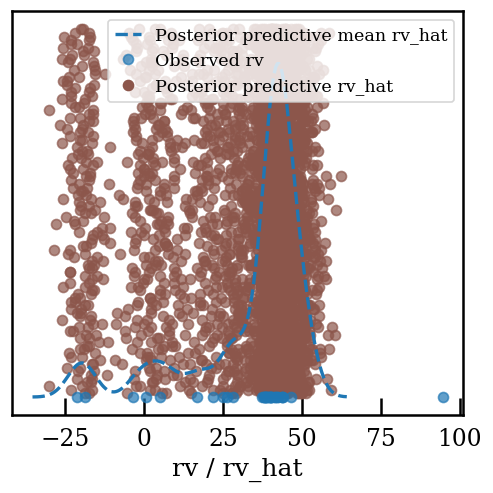

In [22]:
az.plot_ppc(
    azfit,
    data_pairs={"rv": "rv_hat"},
    var_names="rv",
    num_pp_samples=100,
    kind="scatter",
)

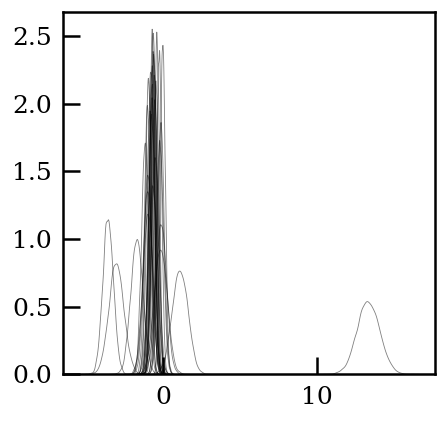

In [17]:
for i in range(stanfit.data['Nrv']):
    sns.distplot(rv_res[:,i], hist=False, kde_kws={'lw':.5, 'color':'k', 'alpha':0.5})
# plt.plot(x, sp.stats.norm.pdf(x), 'k-');

In [23]:
g = m.calculate_veca_residual(stanfit)

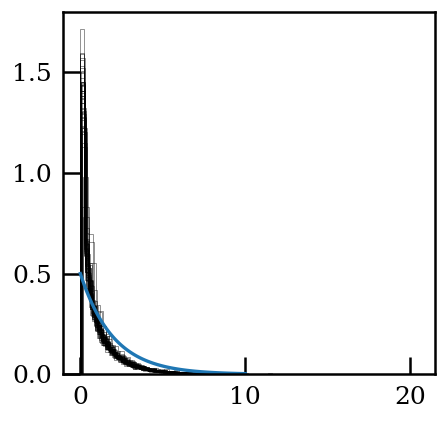

In [33]:
for i in range(50):
    #     sns.distplot(g[:,i], hist=False, kde_kws={'lw':.5, 'color':'k', 'alpha':0.5});
    sns.distplot(
        g[:, i],
        hist=True,
        kde=False,
        hist_kws={
            "histtype": "step",
            "lw": 0.5,
            "color": "k",
            "alpha": 0.5,
            "density": True,
        },
    )
x = np.linspace(0, 10, 101)
pdfx = sp.stats.chi2(df=2).pdf(x)
plt.plot(x, pdfx)

0


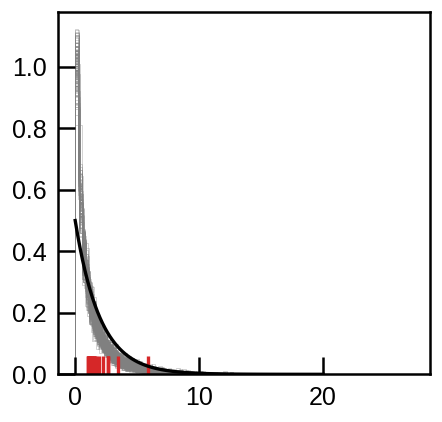

In [45]:
plt.figure(figsize=(4,4))
for i in range(200):
    #     sns.distplot(g[i,:], hist=False, kde_kws={'lw':.5, 'color':'k'});
    sns.distplot(
        g[i, :],
        hist=True,
        kde=False,
        hist_kws={"histtype": "step", "lw": 0.5, "color": "grey", "density": True},
    )
x = np.linspace(0, 20, 101)
pdfx = sp.stats.chi2(df=2).pdf(x)
plt.plot(x, pdfx, "k-", )

# check where RV outliers are
sns.rugplot(g.mean(axis=0)[idx_rv_outliers], color='tab:red', lw=2)

print(np.sum(g.mean(axis=0)>15.63))
# sns.distplot(g[:,187], hist=False, kde_kws={'lw':2});

## first iteration

In [34]:
df_rvcleaned_dr2 = (
    data.copy().drop(index=idx_rv_outliers).reset_index(drop=True)
)

In [35]:
%%time
m = kn.Fitter() 
stanfit, azfit = {}, {}

stanfit['rvcleaned'] = m.fit(df_rvcleaned_dr2, b0=b0, pars=None)
azfit['rvcleaned'] = az.from_pystan(stanfit['rvcleaned'])

INFO:kinesis.models:Reading model from disk


CPU times: user 1min 42s, sys: 3.33 s, total: 1min 46s
Wall time: 14min 26s


In [36]:
az.summary(azfit['rvcleaned'], var_names=['v0', 'sigv', 'T_param'])

,mean,sd,mcse_mean,mcse_sd,hpd_3%,hpd_97%,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
v0[0],-6.003,0.037,0.001,0.000,-6.071,-5.936,4877.0,4877.0,4884.0,3329.0,1.0
v0[1],45.310,0.053,0.001,0.001,45.208,45.408,4353.0,4353.0,4349.0,3389.0,1.0
v0[2],5.390,0.035,0.001,0.000,5.324,5.456,4781.0,4780.0,4793.0,3024.0,1.0
sigv,0.957,0.016,0.000,0.000,0.928,0.986,6168.0,6168.0,6176.0,2682.0,1.0
"T_param[0,0]",-10.297,4.385,0.072,0.052,-18.143,-1.817,3700.0,3570.0,3686.0,3180.0,1.0
"T_param[0,1]",-5.656,2.073,0.032,0.024,-9.464,-1.754,4192.0,3772.0,4183.0,3185.0,1.0
"T_param[0,2]",-0.004,2.228,0.033,0.035,-4.069,4.339,4510.0,2084.0,4525.0,2870.0,1.0
"T_param[1,0]",19.193,6.086,0.105,0.076,7.458,30.063,3332.0,3236.0,3321.0,2728.0,1.0
"T_param[1,1]",18.369,2.774,0.046,0.032,13.252,23.736,3659.0,3659.0,3657.0,3125.0,1.0
"T_param[1,2]",-19.176,2.999,0.047,0.034,-24.727,-13.473,4002.0,4002.0,4005.0,3001.0,1.0


In [101]:
%time rv_res = m.calculate_rv_residual(stanfit['rvcleaned'])

# outliers by 3-sigma
bool_rv_outliers = np.abs(rv_res.mean(axis=0))>3
idx_rv_outliers = stanfit['rvcleaned'].data['irv'][bool_rv_outliers]
print(bool_rv_outliers.sum())
print("index of outliers in original df :", idx_rv_outliers)

KeyError: 'rvcleaned'

KeyError: 'rvcleaned'

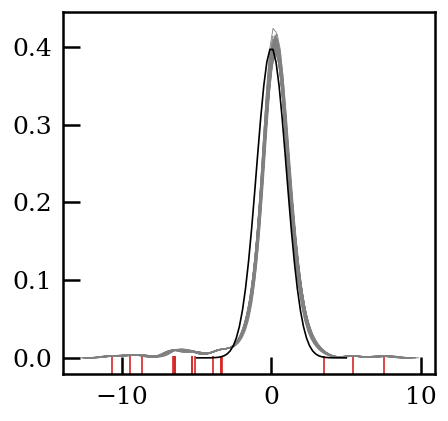

In [38]:
for i in np.random.choice(rv_res.shape[0], size=50):
    sns.distplot(rv_res[i], hist=False, kde_kws={'lw':.5, 'color':'gray'})
x=np.linspace(-5,5)
plt.plot(x, sp.stats.norm.pdf(x), 'k-', lw=1);
# highlight outliers
sns.rugplot(rv_res.mean(axis=0)[bool_rv_outliers], color='tab:red');

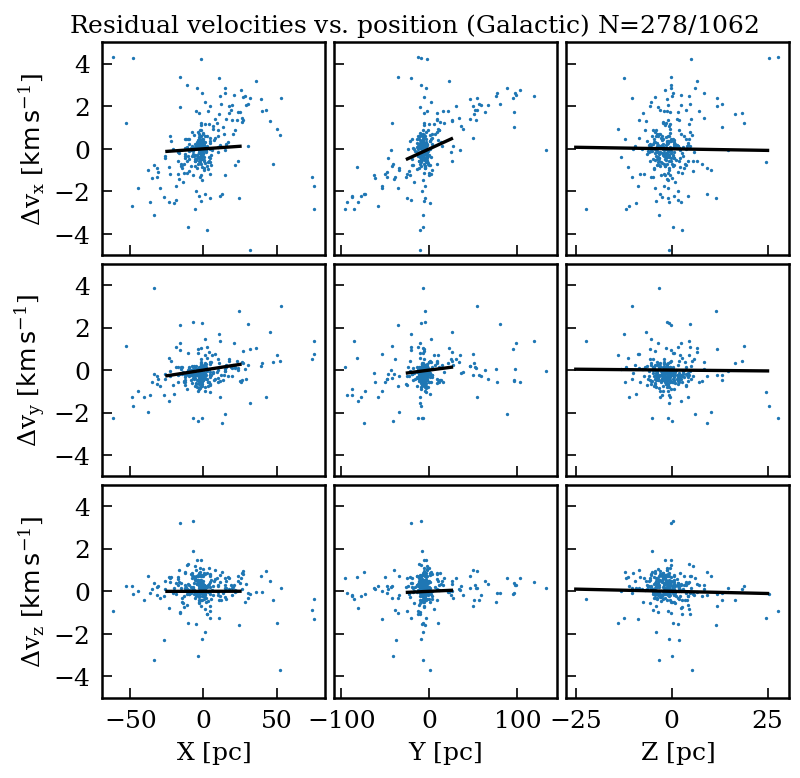

In [77]:
mean_cartv_galactic = [-42.24, -19.00, -1.48]
fig, ax = plt.subplots(
    3, 3, figsize=(6.5, 6.5), sharex="col", sharey="all"
)

dset = df_rvcleaned_dr2_2
cartx, cartv = dset.g.galactic.cartesian, dset.g.galactic.velocity
dvx, dvy, dvz = cartv.d_xyz.value - np.array(mean_cartv_galactic)[:, None]

xyz = cartx.xyz.value
dvxyz = [dvx, dvy, dvz]
TT = rotate_T_to_galactic(stanfit['rvcleaned_2']['T_param'])

for icol in range(3):
    for irow in range(3):
        ax[irow, icol].scatter(xyz[icol]-xyz[icol].mean(), dvxyz[irow], s=1)
        x = np.linspace(-25,25,21)
        ax[irow, icol].plot(x, TT[:,irow,icol].mean()*x/1e3, c='k')

ax[0, 0].set_ylim(-5, 5)
for cax in ax.ravel():
    cax.set_yticks([-4, -2, 0, 2, 4])
    cax.tick_params(width=1, length=6)
fig.subplots_adjust(wspace=0.04, hspace=0.04, left=0.15, bottom=0.15, top=0.94)
for cax, label in zip(ax[:, 0], ["x", "y", "z"]):
    cax.set_ylabel(
        r"$\Delta v_{0}$".format(label) + r" [$\mathrm{km}\,\mathrm{s}^{-1}$]"
    )
ax[2, 0].set_xlabel("$X$ [pc]")
ax[2, 1].set_xlabel("$Y$ [pc]")
ax[2, 2].set_xlabel("$Z$ [pc]")
fig.suptitle(
    "Residual velocities vs. position (Galactic) $N$={}/{}".format(
        (~np.isnan(dvx)).sum(), len(dset)
    ), size=15
)
fig.subplots_adjust(right=0.98, left=0.1, bottom=0.1)

# fig.savefig("../plots/residual-velocity-vs-position-galactic.pdf")

In [259]:
%run smoh_utils.ipynb

In [271]:
aa=azfit['vanilla']

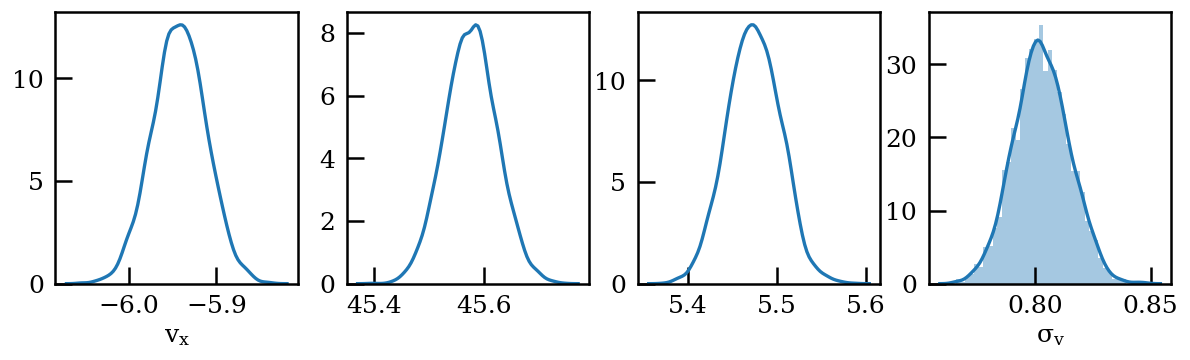

In [92]:
fig, ax = plt.subplots(1, 4, figsize=(12,3))

for i in range(3):
    sns.distplot(stanfit['rvcleaned_2']['v0'][:,i],ax=ax[i], hist=False);
ax[0].set_xlabel("$v_x$");

# sns.distplot(stanfit['vanilla']['sigv'], ax=ax[3])
sns.distplot(stanfit['rvcleaned_2']['sigv'],ax=ax[3]);
ax[3].set_xlabel("$\sigma_v$");

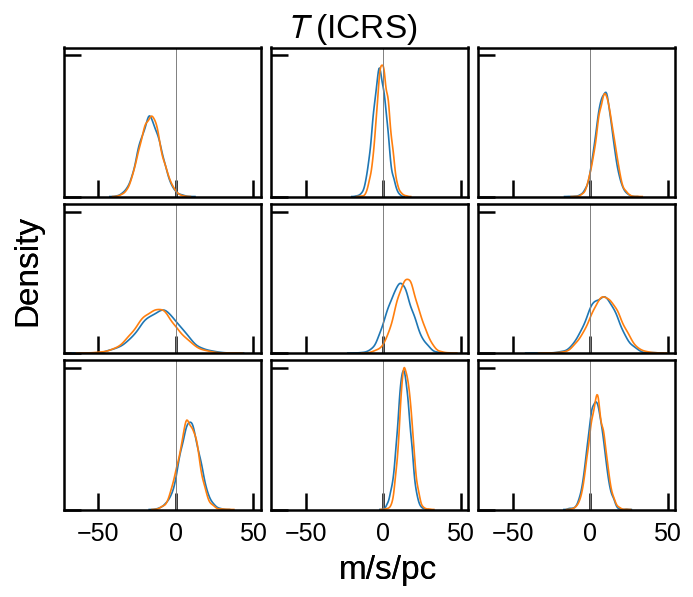

In [260]:
fig=plot_T_icrs(stanfit['vanilla'])
fig=plot_T_icrs(stanfit['rvcleaned'], fig=fig)

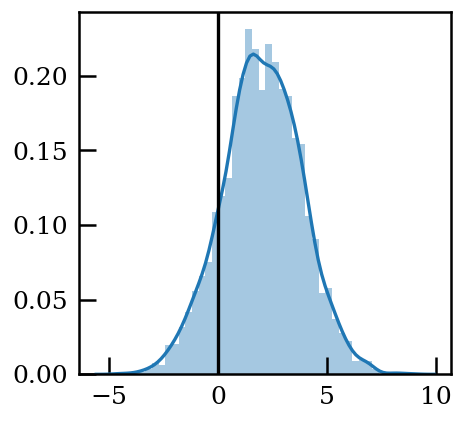

In [90]:
plt.figure(figsize=(4,4))
sns.distplot(
    decompose_T(rotate_T_to_galactic(stanfit["rvcleaned_2"]["T_param"]))["kappa"]
)
plt.axvline(0, c='k')

In [85]:
T_galactic = rotate_T_to_galactic(stanfit['rvcleaned_2']["T_param"])
T_sym = (T_galactic + np.transpose(T_galactic, (0, 2, 1))) / 2.
T_antisym = (T_galactic - np.transpose(T_galactic, (0, 2, 1))) / 2.

In [86]:
# math check
assert (
    (T_antisym[:, 2, 1] == decompose_T(T_galactic)["omegax"]).all(),
    (T_antisym[:, 0, 2] == decompose_T(T_galactic)["omegay"]).all(),
    (T_antisym[:, 1, 0] == decompose_T(T_galactic)["omegaz"]).all(),
) == (True, True, True)

In [87]:
# decompose and sort by eigenvalues
w, v = np.linalg.eig(T_sym)

i_wsort = np.argsort(w, axis=1)
# my numpy-fu running out...
sorted_v = np.stack([v[j][:,i] for j, i in enumerate(i_wsort)])
sorted_w = np.sort(w, axis=1)

# verify math
assert np.allclose(sorted_w.mean(axis=1), decompose_T(T_galactic)["kappa"]) == True

In [32]:
# sorted_v[:,:,0] *= np.sign(sorted_v[:,2,0])[:,None]
# sorted_v[:,:,1] *= np.sign(sorted_v[:,2,1])[:,None]
# sorted_v[:,:,2] *= np.sign(sorted_v[:,2,2])[:,None]

 -11.257 +-    2.609 (   4.315) 0.05379, -0.05439,  0.04372
  -3.000 +-    3.591 (   0.835)-0.08167,  0.12248,  0.82543
  20.339 +-    1.574 (  12.918)-0.02920, -0.02961, -0.00093


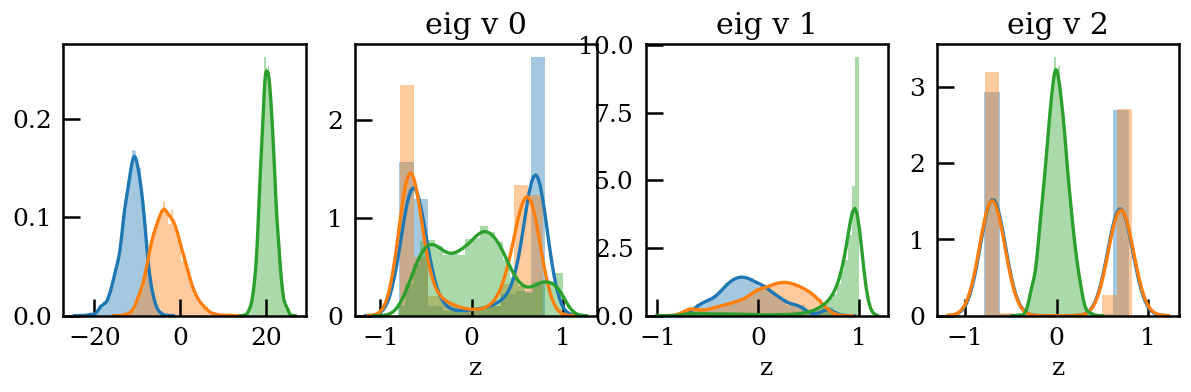

In [88]:
fig, ax = plt.subplots(1, 4, figsize=(12, 3))
sns.distplot(sorted_w.T[0], ax=ax[0])
sns.distplot(sorted_w.T[1], ax=ax[0])
sns.distplot(sorted_w.T[2], ax=ax[0]);

for i in range(3):
    vd = pd.DataFrame(sorted_v[:,:,i], columns=['x','y','z'])
    for col in vd:
        sns.distplot(vd[col], ax=ax[i+1])#, legend=False)
    ax[i+1].set_title(f"eig v {i}")

for i, cw in enumerate(sorted_w.T):
    print(f"{np.mean(cw):8.3f} +- {np.std(cw):8.3f} ({np.abs(np.mean(cw)/np.std(cw)):8.3f})", end='')
    print(f"{np.mean(sorted_v[:,0,i]):-8.5f}, {np.mean(sorted_v[:,1,i]):-8.5f}, {np.mean(sorted_v[:,2,i]):-8.5f}")

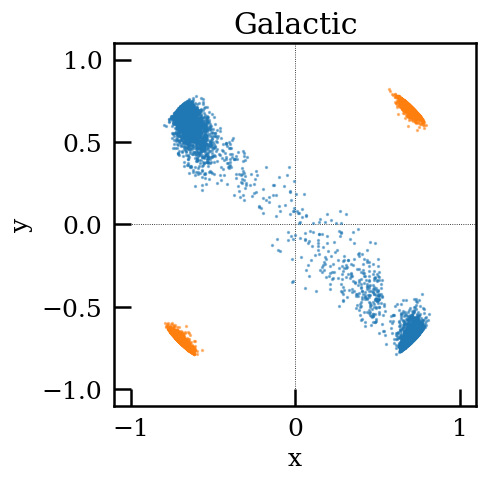

In [140]:
plt.scatter(sorted_v[:,0,0], sorted_v[:,1,0], alpha=.5, s=1, label='eigv 0')
plt.scatter(sorted_v[:,0,2], sorted_v[:,1,2], alpha=.5, s=1, label='eigv 2')
plt.gca().set_aspect('equal')
plt.axis([-1.1,1.1,-1.1,1.1])
plt.axvline(0, c='k', ls=':', zorder=-2, lw=.5)
plt.axhline(0, c='k', ls=':', zorder=-2, lw=.5)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('Galactic');

In [ ]:
df_rvcleaned_dr2.g.vra_erro

## Null test

We make a cluster with $T=0$.

In [497]:
v0 = [-6.07, 45.66, 5.53]
b0 = [17.27, 41.64, 13.60]
sigmav = 0.38
print(f"b0=f{b0}")
clT0 = (
    kn.Cluster(v0=v0, sigmav=sigmav, b0=b0)
    .sample_at(df_rvcleaned_dr2.g.icrs)
    .observe(cov=df_rvcleaned_dr2.g.make_cov())
)

b0=f[17.27, 41.64, 13.6]


In [498]:
df_mock_T0 = clT0.members.observed.copy()
df_mock_T0["radial_velocity_error"] = df_rvcleaned_dr2["radial_velocity_error"]
df_mock_T0["radial_velocity"] = np.random.normal(
    clT0.members.truth["radial_velocity"].values,
    scale=df_mock_T0["radial_velocity_error"].values,
)

In [513]:
%%time
m = kn.Fitter()
stanfit['mockT0_4'] = m.fit(df_mock_T0, b0=b0, pars=None)
azfit['mockT0_4'] = az.from_pystan(stanfit['mockT0_4'])

INFO:kinesis.models:Reading model from disk


CPU times: user 43.5 s, sys: 5.89 s, total: 49.4 s
Wall time: 8min 17s


In [467]:
az.summary(azfit['mockT0'], var_names=['v0', 'sigv', 'T_param'])

,mean,sd,mcse_mean,mcse_sd,hpd_3%,hpd_97%,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
v0[0],-6.072,0.024,0.000,0.000,-6.117,-6.026,2372.0,2372.0,2373.0,2943.0,1.0
v0[1],45.755,0.042,0.001,0.001,45.676,45.833,2146.0,2146.0,2150.0,2436.0,1.0
v0[2],5.559,0.022,0.000,0.000,5.518,5.600,2356.0,2356.0,2356.0,2356.0,1.0
sigv,0.391,0.009,0.000,0.000,0.375,0.408,3685.0,3685.0,3689.0,3088.0,1.0
"T_param[0,0]",-0.507,7.031,0.147,0.104,-14.260,12.259,2287.0,2287.0,2286.0,2966.0,1.0
"T_param[0,1]",4.536,4.495,0.097,0.069,-3.621,13.086,2146.0,2146.0,2146.0,2877.0,1.0
"T_param[0,2]",-0.728,5.545,0.121,0.086,-10.654,10.108,2087.0,2087.0,2087.0,2654.0,1.0
"T_param[1,0]",-0.173,13.023,0.299,0.212,-24.023,23.850,1893.0,1893.0,1891.0,2513.0,1.0
"T_param[1,1]",7.923,7.704,0.167,0.118,-6.893,22.284,2129.0,2129.0,2128.0,2655.0,1.0
"T_param[1,2]",-11.455,10.118,0.226,0.160,-30.487,7.332,2009.0,2009.0,2009.0,2856.0,1.0


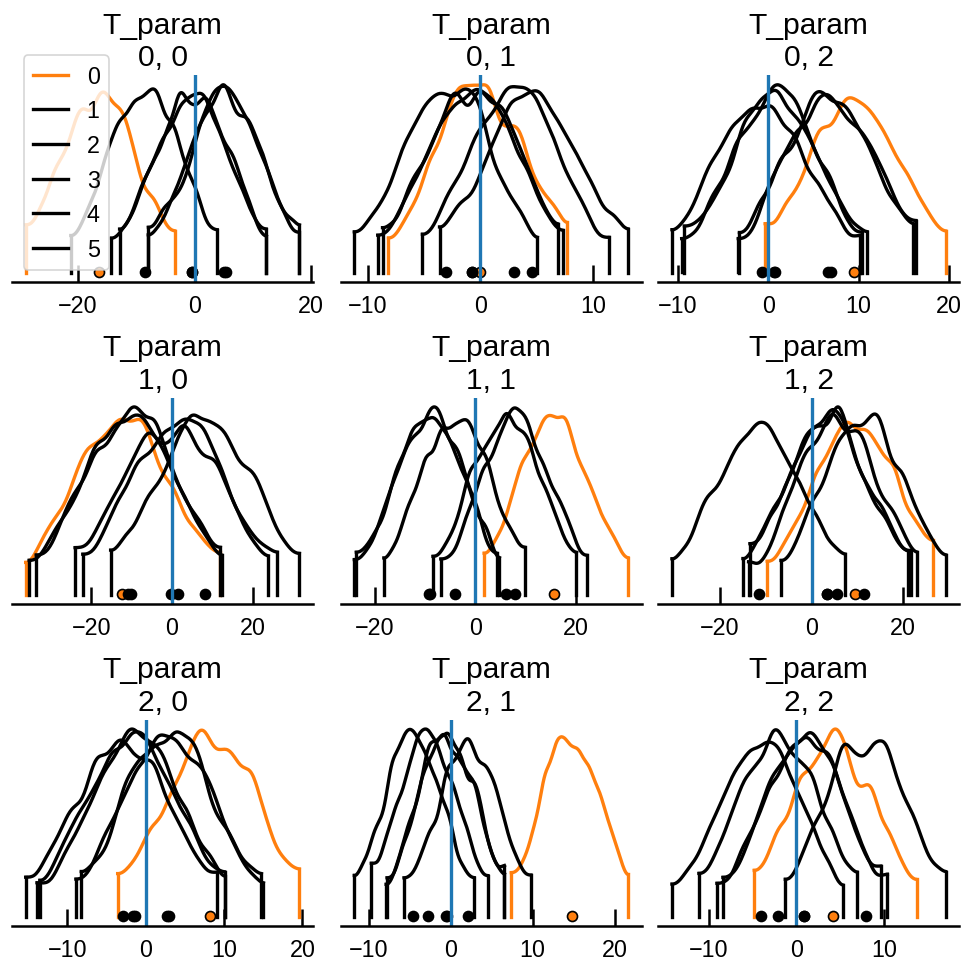

In [516]:
ax = az.plot_density(
    [
        azfit["rvcleaned"],
        azfit["mockT0"],
        azfit["mockT0_1"],
        azfit["mockT0_2"],
        azfit["mockT0_3"],
        azfit["mockT0_4"],
    ],
    var_names="T_param",
    colors=["tab:orange", "k", "k", "k", "k", "k"],
    figsize=(8, 8),
)
for cax in ax:
    cax.axvline(0)

In [507]:
%run smoh_utils.ipynb

In [531]:
v = rotate_T_to_galactic(stanfit['rvcleaned']['T_param'])[:,2,2]
print(f"{'rvcleaned':8s}", f"{np.mean(v):-8.3f} {np.std(v):-8.3f} {np.abs(np.mean(v))/np.std(v):-8.3f}")
for label, fit in stanfit.items():
    if 'mock' in label:
        v = rotate_T_to_galactic(fit['T_param'])[:,2,2]
        print(f"{label:8s}", f"{np.mean(v):-8.3f} {np.std(v):-8.3f} {np.abs(np.mean(v))/np.std(v):-8.3f}")

rvcleaned  -22.133    7.058    3.136
mockT0      2.120    7.440    0.285
mockT0_1   -9.228    7.101    1.300
mockT0_2    0.501    7.000    0.072
mockT0_3    0.276    7.240    0.038
mockT0_4    0.083    7.072    0.012


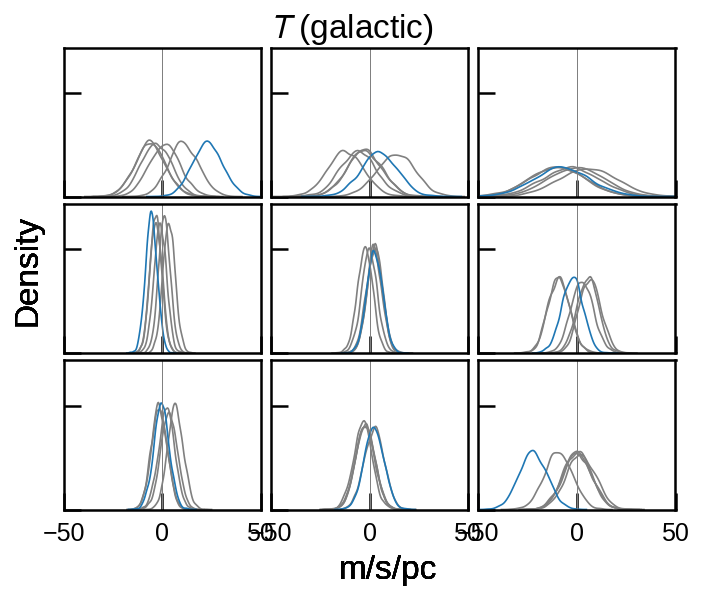

In [517]:
fig = plot_T_galactic(stanfit['mockT0'], color='gray')
fig = plot_T_galactic(stanfit['mockT0_1'], fig=fig, color='gray')
fig = plot_T_galactic(stanfit['mockT0_2'], fig=fig,color='gray')
fig = plot_T_galactic(stanfit['mockT0_3'], fig=fig,color='gray')
fig = plot_T_galactic(stanfit['mockT0_4'], fig=fig,color='gray')
fig = plot_T_galactic(stanfit['rvcleaned'], fig=fig)
for cax in fig.axes:cax.set_xlim(-50,50)

In [6]:
stanfit = {}
azfit = {}

## What signal?

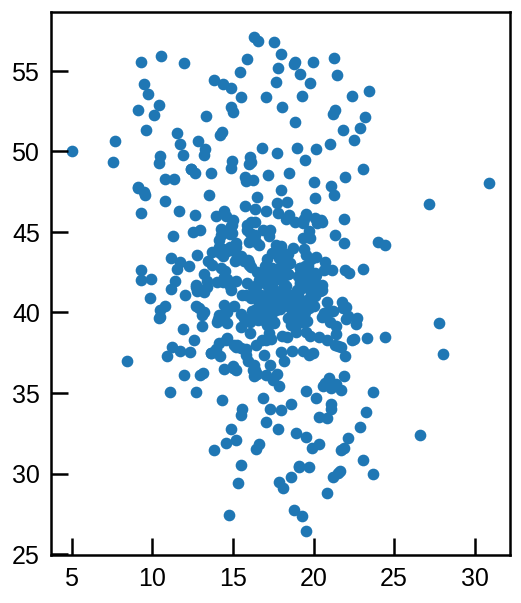

In [688]:
coi = df_rvcleaned_dr2.g.icrs
cog = df_rvcleaned_dr2.g.galactic.cartesian
plt.axes(aspect='equal')
plt.scatter(coi.x, coi.y);


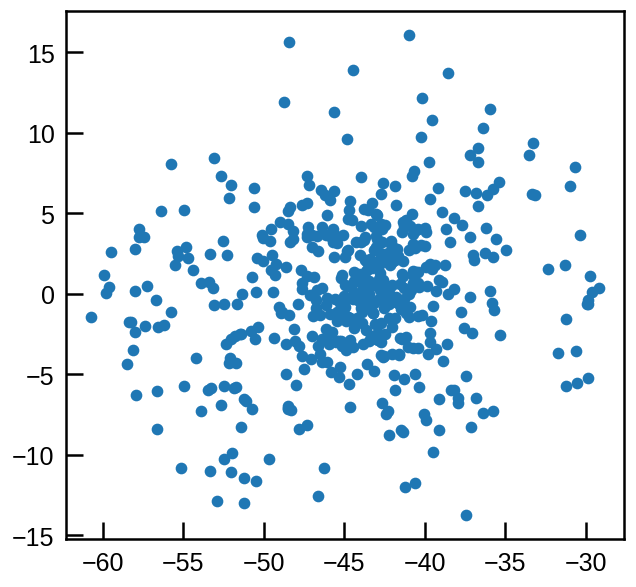

In [689]:
coi = df_rvcleaned_dr2.g.icrs.cartesian
cog = df_rvcleaned_dr2.g.galactic.cartesian
plt.axes(aspect='equal')
plt.scatter(cog.x, cog.y);


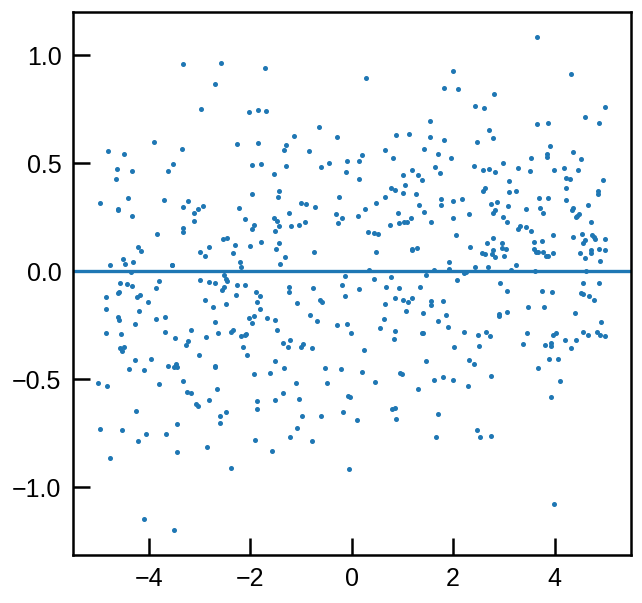

In [546]:
x = np.random.uniform(-5, 5, 500)
y = np.random.normal(scale=0.38, size=500) + x*20*1e-3
plt.scatter(x, y, s=4);
plt.axhline(0);

In [559]:
b0_coord = coord.ICRS(x=b0[0]*u.pc, y=b0[1]*u.pc, z=b0[2]*u.pc,
                      representation_type='cartesian')
b0_gal = b0_coord.transform_to(coord.Galactic).cartesian.xyz

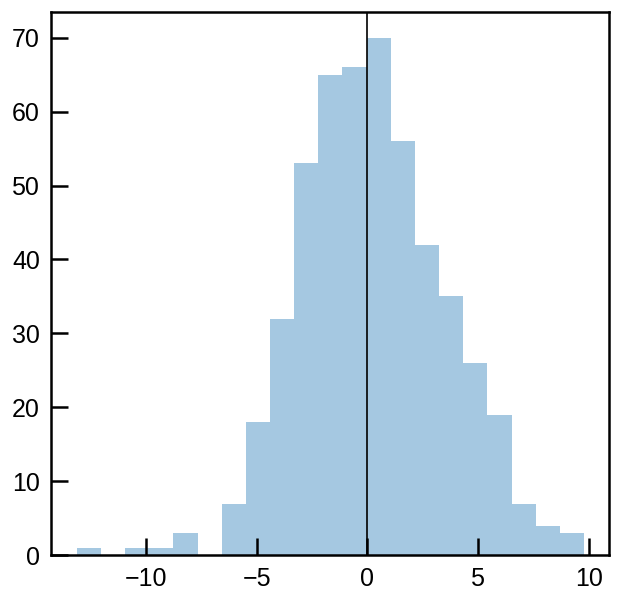

In [564]:
sns.distplot(df_rvcleaned_dr2.g.galactic.cartesian.z-b0_gal[2], kde=False);
plt.axvline(0,c='k', lw=1);

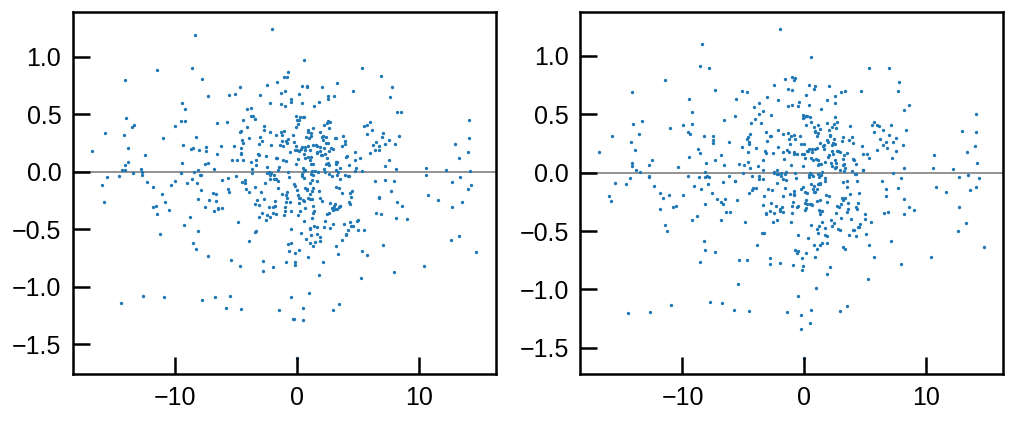

In [597]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].scatter(
    df_rvcleaned_dr2.g.galactic.cartesian.x - b0_gal[0],
    df_rvcleaned_dr2.g.vra - cl.members.truth.g.vra,
    s=1,
)
ax[1].scatter(
    df_rvcleaned_dr2.g.galactic.cartesian.x - b0_gal[0],
    df_rvcleaned_dr2.g.vra - clT.members.truth.g.vra,
    s=1,
)
for cax in ax: cax.axhline(0, lw=1, c='gray', zorder=-10);

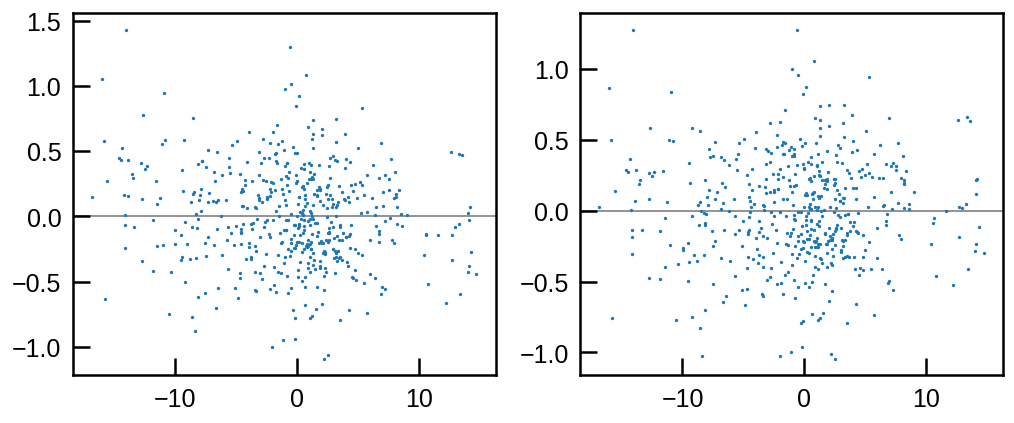

In [599]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].scatter(
    df_rvcleaned_dr2.g.galactic.cartesian.x - b0_gal[0],
    df_rvcleaned_dr2.g.vdec - cl.members.truth.g.vdec,
    s=1,
)
ax[1].scatter(
    df_rvcleaned_dr2.g.galactic.cartesian.x - b0_gal[0],
    df_rvcleaned_dr2.g.vdec - clT.members.truth.g.vdec,
    s=1,
)
for cax in ax: cax.axhline(0, lw=1, c='gray', zorder=-10);

In [601]:
coord.ICRS(x=3, y=4, z=0, representation_type="cartesian").transform_to(
    coord.Galactic
).cartesian.xyz

<Quantity [-3.65837518, -0.29699057, -3.39530376]>

In [607]:
cc = coord.ICRS(
    x=0 * u.pc,
    y=0 * u.pc,
    z=0 * u.pc,
    v_x=1 * u.km / u.s,
    v_y=0 * u.km / u.s,
    v_z=0 * u.km / u.s,
    representation_type="cartesian",
    differential_type="cartesian",
).transform_to(coord.Galactic)

In [608]:
cc.cartesian, cc.velocity

(<CartesianRepresentation (x, y, z) in pc
     (0., 0., 0.)
  (has differentials w.r.t.: 's')>,
 <CartesianDifferential (d_x, d_y, d_z) in km / s
     (-0.05487566, 0.49410944, -0.86766614)>)

In [715]:
tmp = df_rvcleaned_dr2.copy()
tmp['radial_velocity'] = cl.members.truth['radial_velocity']
# tmp['radial_velocity'] = 0.

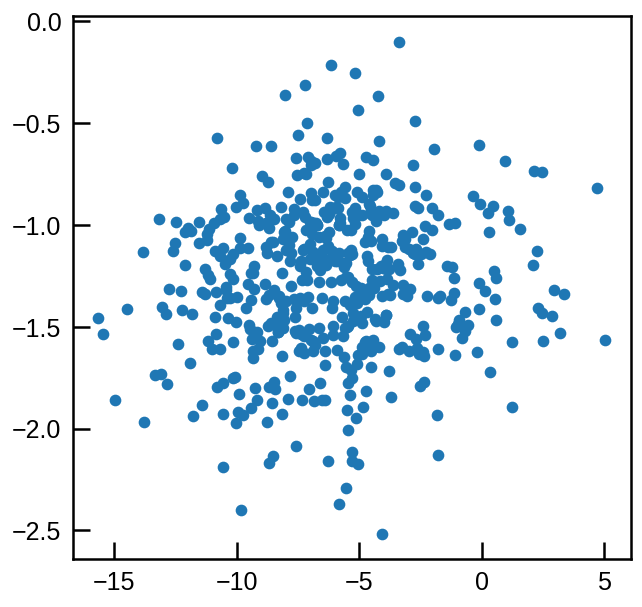

In [716]:
# plt.axes(aspect='equal')
plt.scatter(tmp.g.vdec, tmp.g.galactic.velocity.d_z)

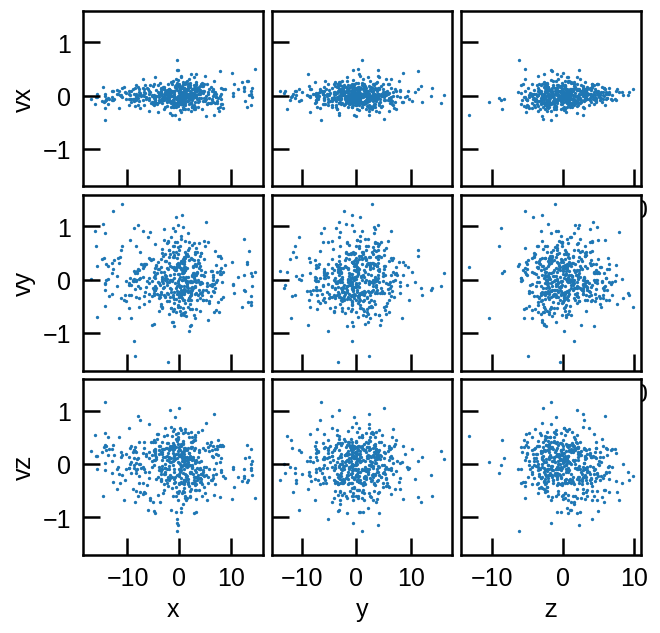

In [717]:
fig, ax = plt.subplots(3, 3, figsize=(6,6), sharex=False, sharey=True)
fig.subplots_adjust(wspace=.05, hspace=.05)

pos = tmp.g.galactic.cartesian.xyz
vel = tmp.g.galactic.velocity.d_xyz
relpos = pos - np.median(pos, axis=1)[:,None]
relvel = vel - np.median(vel, axis=1)[:,None]

ax[0,0].scatter(relpos[0], relvel[0], s=1)
ax[1,0].scatter(relpos[0], relvel[1], s=1)
ax[2,0].scatter(relpos[0], relvel[2], s=1)

ax[0,1].scatter(relpos[1], relvel[0], s=1)
ax[1,1].scatter(relpos[1], relvel[1], s=1)
ax[2,1].scatter(relpos[1], relvel[2], s=1)

ax[0,2].scatter(relpos[2], relvel[0], s=1)
ax[1,2].scatter(relpos[2], relvel[1], s=1)
ax[2,2].scatter(relpos[2], relvel[2], s=1)

# mrT = rotate_T_to_galactic(stanfit['rvcleaned']['T_param']).mean(axis=0)
# x=np.linspace(-10,10)
# for i in range(3):
#     for j in range(3):
#         ax[i,j].plot(x, mrT[i,j]/1e3*x, c='k', lw=1)

for i, l in enumerate(['x','y','z']): ax[2,i].set_xlabel(l)
for i, l in enumerate(['vx','vy','vz']): ax[i, 0].set_ylabel(l)

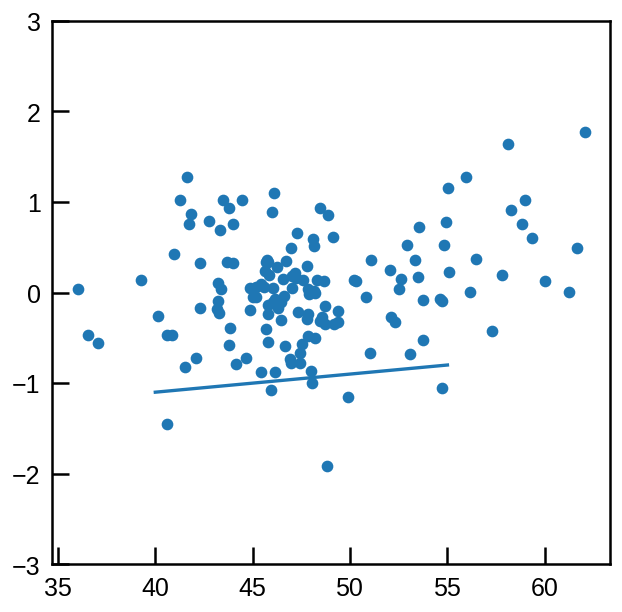

In [702]:
# plt.axes(aspect="equal")
plt.scatter(
    1e3 / df_rvcleaned_dr2["parallax"],
    df_rvcleaned_dr2["radial_velocity"] - cl.members.truth["radial_velocity"],
)
plt.ylim(-3,3)
x=np.linspace(40,55)
plt.plot(x, 20e-3*(x-45)-1)

In [678]:
sp.stats.pearsonr(
    tmp.g.galactic.cartesian.z-np.median(tmp.g.galactic.cartesian.z),
    tmp.g.galactic.velocity.d_z)

(-0.14147312541038207, 0.00137408030681297)

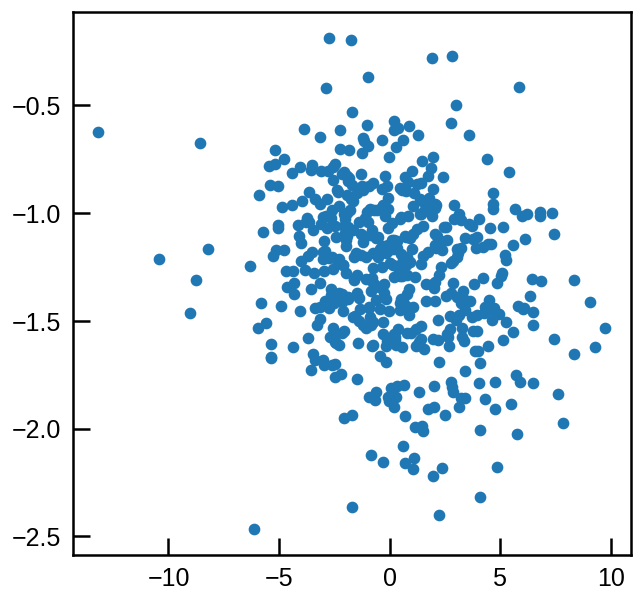

In [683]:
plt.scatter(
    tmp.g.galactic.cartesian.z-np.median(tmp.g.galactic.cartesian.z),
    tmp.g.galactic.velocity.d_z)

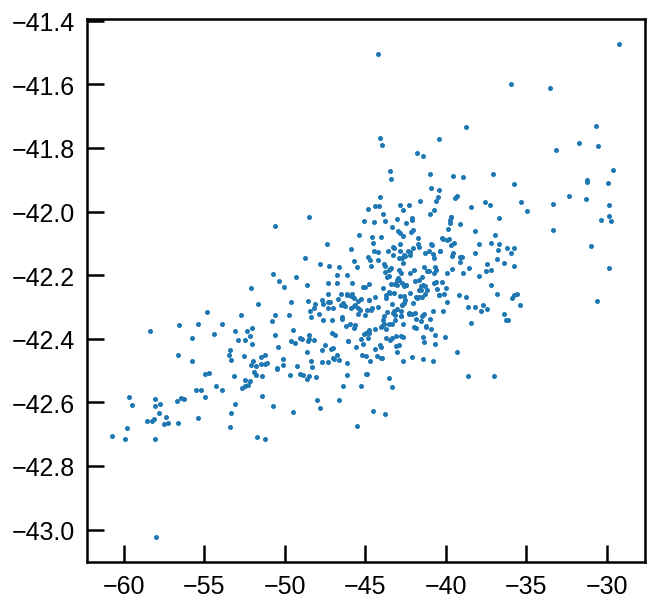

In [684]:
plt.scatter(
    tmp.g.galactic.cartesian.x,
    tmp.g.galactic.velocity.d_x, s=4)
# plt.scatter(
#     df_rvcleaned_dr2.g.galactic.cartesian.x,
#     df_rvcleaned_dr2.g.galactic.velocity.d_x, s=4)
# plt.ylim(-45,-40)
# x=np.linspace(-55,-35)
# plt.plot(x, 20e-3*(x+45)-43)

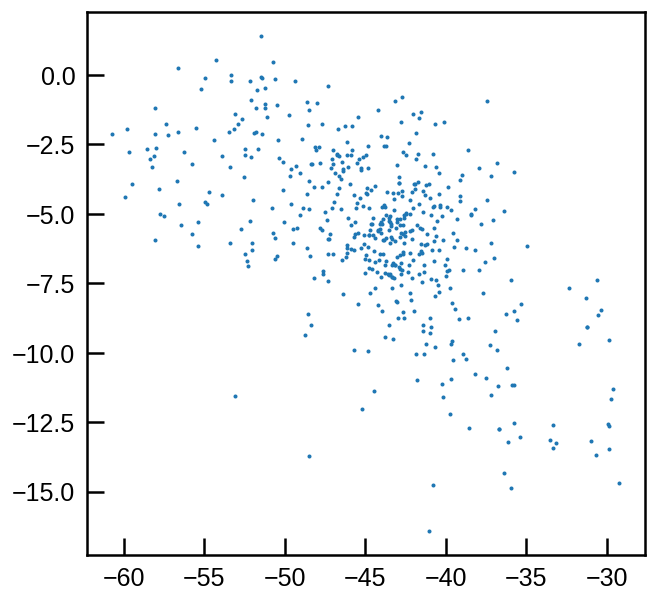

In [627]:
plt.scatter(
    tmp.g.galactic.cartesian.x,
    tmp.g.galactic.velocity.d_x, s=2)

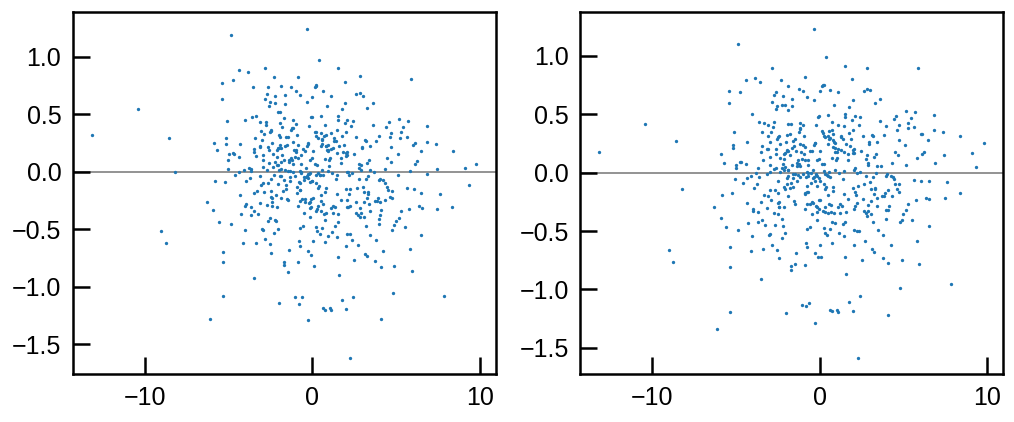

In [594]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].scatter(
    tmp.g.galactic.cartesian.z,
    tmp.g.vra - cl.members.truth.g.vra,
    s=1,
)
ax[1].scatter(
    df_rvcleaned_dr2.g.galactic.cartesian.z - b0_gal[2],
    df_rvcleaned_dr2.g.vra - clT.members.truth.g.vra,
    s=1,
)
for cax in ax: cax.axhline(0, lw=1, c='gray', zorder=-10);

In [ ]:
df_rvcleaned_dr2.g.

In [600]:
rotmat

array([[-0.05487566, -0.87343705, -0.48383507],
       [ 0.49410944, -0.44482972,  0.74698218],
       [-0.86766614, -0.19807634,  0.45598381]])

In [602]:
np.einsum('ij,j->i', rotmat, [3,4,0])

array([-3.65837518, -0.29699057, -3.39530376])

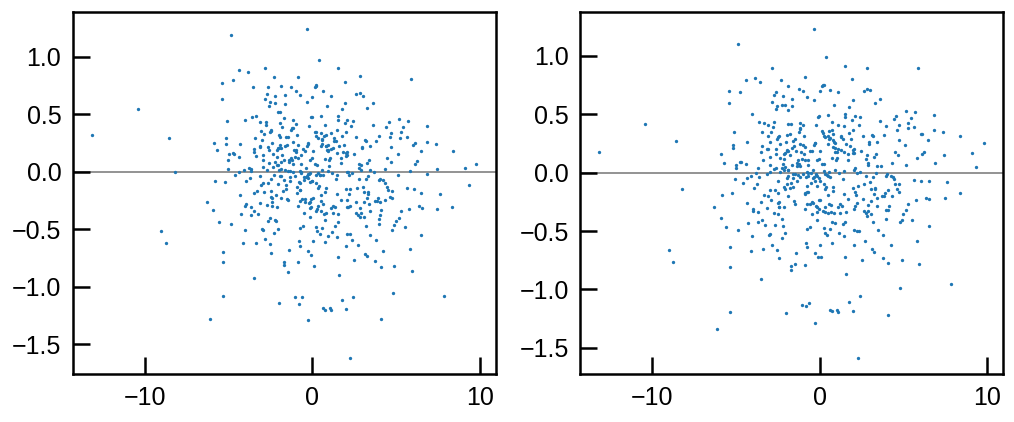

In [594]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].scatter(
    df_rvcleaned_dr2.g.galactic.cartesian.z - b0_gal[2],
    df_rvcleaned_dr2.g.vra - cl.members.truth.g.vra,
    s=1,
)
ax[1].scatter(
    df_rvcleaned_dr2.g.galactic.cartesian.z - b0_gal[2],
    df_rvcleaned_dr2.g.vra - clT.members.truth.g.vra,
    s=1,
)
for cax in ax: cax.axhline(0, lw=1, c='gray', zorder=-10);

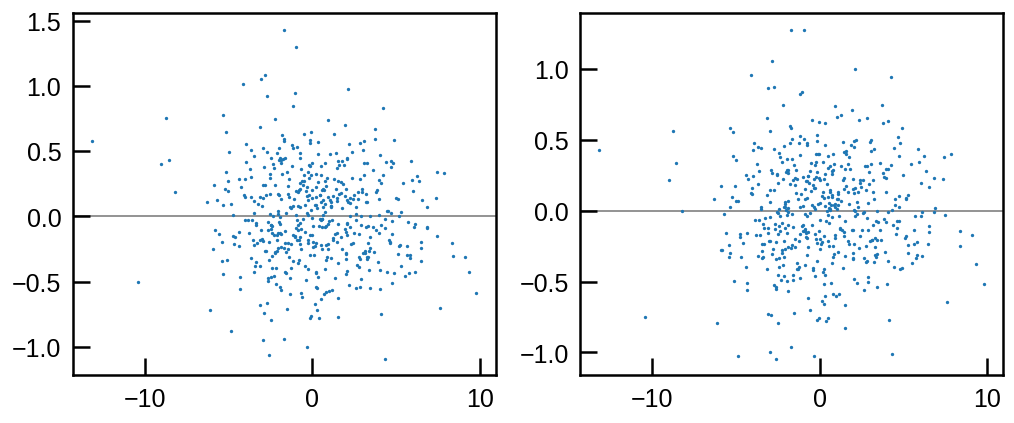

In [595]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].scatter(
    df_rvcleaned_dr2.g.galactic.cartesian.z - b0_gal[2],
    df_rvcleaned_dr2.g.vdec - cl.members.truth.g.vdec,
    s=1,
)
ax[1].scatter(
    df_rvcleaned_dr2.g.galactic.cartesian.z - b0_gal[2],
    df_rvcleaned_dr2.g.vdec - clT.members.truth.g.vdec,
    s=1,
)
for cax in ax: cax.axhline(0, lw=1, c='gray', zorder=-10);

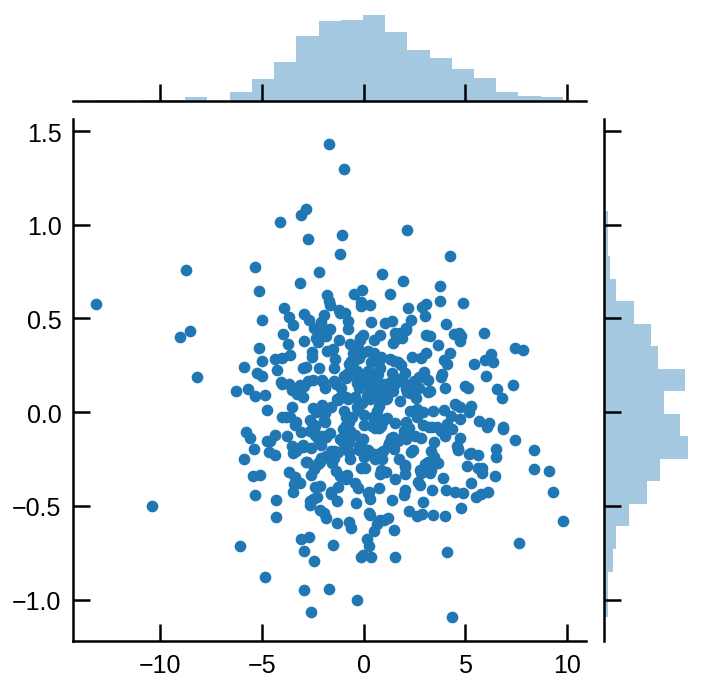

In [572]:
sns.jointplot(df_rvcleaned_dr2.g.galactic.cartesian.z-b0_gal[2],
              df_rvcleaned_dr2.g.vdec-cl.members.truth.g.vdec);

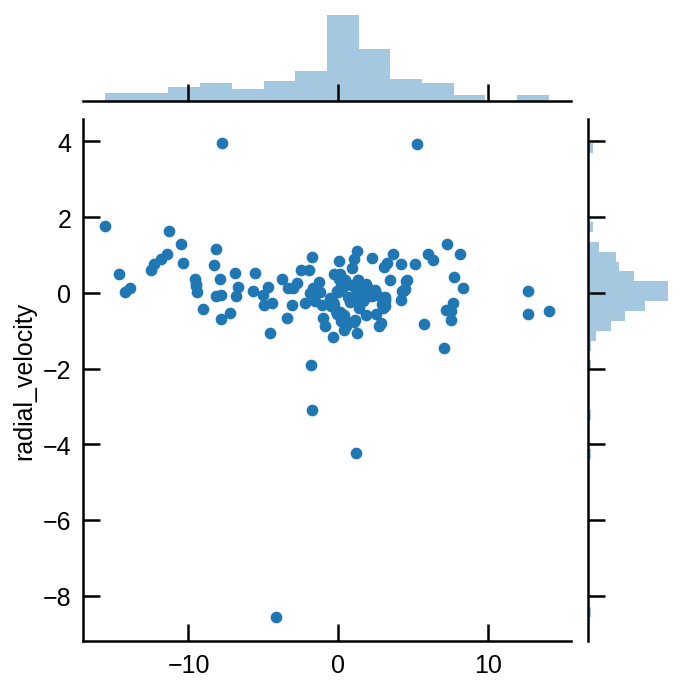

In [575]:
sns.jointplot(df_rvcleaned_dr2.g.galactic.cartesian.x-b0_gal[0],
              df_rvcleaned_dr2['radial_velocity']-cl.members.truth['radial_velocity']);

In [532]:
rotmat = coord.ICRS(
    [1, 0, 0], [0, 1, 0], [0, 0, 1], representation_type=coord.CartesianRepresentation
).transform_to(coord.Galactic).cartesian.xyz.value

In [533]:
rotmat

array([[-0.05487566, -0.87343705, -0.48383507],
       [ 0.49410944, -0.44482972,  0.74698218],
       [-0.86766614, -0.19807634,  0.45598381]])

In [56]:
%%time
stanfit['vanilla'] = m.fit(df_vanilla_dr2, b0=b0, pars=None)
azfit['vanilla'] = az.from_pystan(stanfit['vanilla'])

CPU times: user 36.5 s, sys: 1.91 s, total: 38.5 s
Wall time: 7min 43s


In [319]:
fit = stanfit['rvcleaned']

In [372]:
for k,v in decompose_T(fit['T_param']).items():
    print(k, np.mean(v), np.std(v),  np.abs(np.mean(v))/np.std(v))

omegax 2.6237862472763265 5.51679348614289 0.47559986681878996
omegay 0.6145886832943327 4.377935139446534 0.1403832317561539
omegaz -6.172702608925529 6.322453060826883 0.9763145015928724
w1 12.13585292513772 4.944680124763286 2.4543251775500226
w2 8.853413777973328 3.884344294848548 2.2792556750736037
w3 -6.169787790045084 7.148765148448587 0.8630564386891407
w4 -16.343539789038772 6.833365684690961 2.3917262068461813
w5 15.665541192630881 7.638539533715953 2.0508555494783174
kappa 1.1764567995636963 3.8737916552065017 0.3036964566699141


In [368]:
np.abs(fit['T_param'].mean(axis=0))/fit['T_param'].std(axis=0)

array([[2.39172621e+00, 6.88657667e-04, 1.75285563e+00],
       [9.63077657e-01, 2.05085555e+00, 9.75712391e-01],
       [1.31367170e+00, 3.84571580e+00, 8.40706374e-01]])

In [320]:
wT = decompose_T(fit['T_param'].mean(axis=0))

In [321]:
[wT["omegax"], wT["omegay"], wT["omegaz"]]

[array([2.62378625]), array([0.61458868]), array([-6.17270261])]

In [566]:
v0 = fit["v0"].mean(axis=0)
sigmav = fit["sigv"].mean()
print(f"b0=f{b0}")
cl = kn.Cluster(v0=v0, sigmav=0, b0=b0).sample_at(df_rvcleaned_dr2.g.icrs)
clT = kn.Cluster(
    v0=v0,
    sigmav=0,
    b0=b0,
    omegas=[wT["omegax"][0], wT["omegay"][0], wT["omegaz"][0]],
    ws=[wT["w1"][0], wT["w2"][0], wT["w3"][0], wT["w4"][0], wT["w5"][0]],
    k=wT["kappa"][0],
).sample_at(df_rvcleaned_dr2.g.icrs)

b0=f[17.27, 41.64, 13.6]


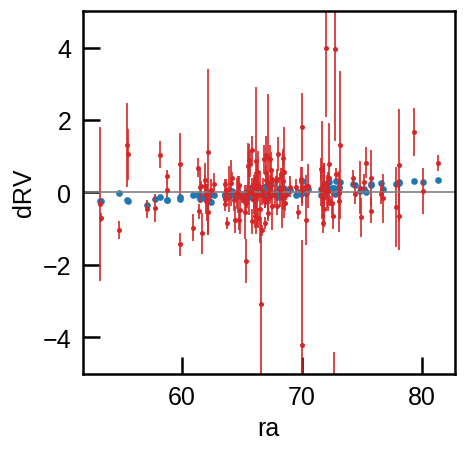

In [447]:
plt.figure(figsize=(4, 4))
# plt.scatter(
#     cl.members.truth.ra,
#     clT.members.truth["radial_velocity"] - cl.members.truth["radial_velocity"],
#     s=9,
# )
plt.xlabel("ra")
plt.ylabel("dRV")

irv = fit.data["irv"]
plt.scatter(
    cl.members.truth.ra[irv],
    (clT.members.truth["radial_velocity"] - cl.members.truth["radial_velocity"])[irv],
    s=9,
)

plt.errorbar(
    fit.data["ra"][irv], fit.data["rv"] - cl.members.truth["radial_velocity"][irv],
    yerr=fit.data["rv_error"], marker='o', elinewidth=1, ls='None', ms=2,
    color='tab:red'
)
plt.ylim(-5,5);
plt.axhline(0, c='gray', lw=1)

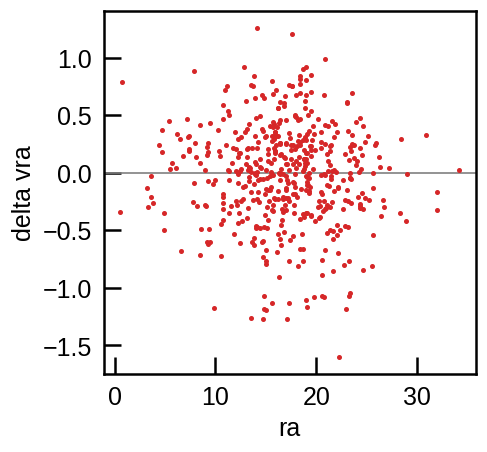

In [417]:
plt.figure(figsize=(4, 4))
plt.xlabel("ra")
plt.ylabel("delta vra")

# plt.scatter(
#     cl.members.truth.dec,
#     (clT.members.truth.g.vra - cl.members.truth.g.vra),
#     s=9,
# )

# plt.scatter(
#     hy_tails_r19_full["dec"], hy_tails_r19_full.g.vra - cl.members.truth.g.vra, s=1
# )

plt.errorbar(
    fit.data["dec"],
    df_rvcleaned_dr2.g.vra - cl.members.truth.g.vra,
    #     yerr=fit.data["rv_error"],
    marker="o",
    elinewidth=1,
    ls="None",
    ms=2,
    color="tab:red",
)
# plt.ylim(-5,5);
plt.axhline(0, c="gray", lw=1)

In [387]:
sp.stats.pearsonr(df_rvcleaned_dr2.g.icrs.cartesian.y,
    df_rvcleaned_dr2.g.vdec - cl.members.truth.g.vdec,)

(0.12816599966398015, 0.0037746905736643203)

In [413]:
np.mean(
    
    (clT.members.truth.g.vra - cl.members.truth.g.vra)/
cl.members.truth.g.icrs.cartesian.z.value)

-0.00042116693257929645

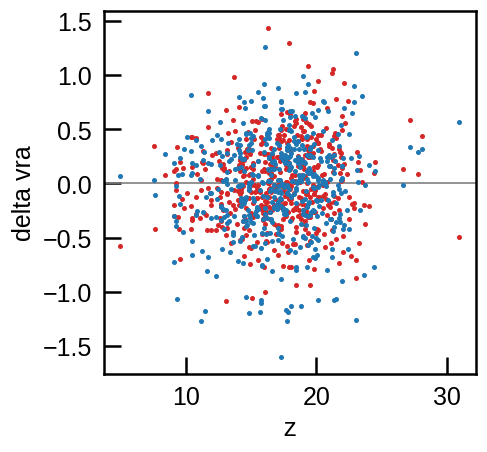

In [424]:
plt.figure(figsize=(4, 4))
plt.xlabel("z")
plt.ylabel("delta vra")


# plt.scatter(
#     cl.members.truth.g.icrs.cartesian.z,
#     (clT.members.truth.g.vra - cl.members.truth.g.vra),
#     s=9,
# )

plt.errorbar(
    df_rvcleaned_dr2.g.icrs.cartesian.x,
    df_rvcleaned_dr2.g.vdec - cl.members.truth.g.vdec,
    #     yerr=fit.data["rv_error"],
    marker="o",
    elinewidth=1,
    ls="None",
    ms=2,
    color="tab:red",
)
plt.errorbar(
    df_rvcleaned_dr2.g.icrs.cartesian.x,
    df_rvcleaned_dr2.g.vra - cl.members.truth.g.vra,
    #     yerr=fit.data["rv_error"],
    marker="o",
    elinewidth=1,
    ls="None",
    ms=2,
)

# plt.ylim(-5,5);
plt.axhline(0, c="gray", lw=1)
# x = np.linspace(1, 10)
# plt.plot(x, -0.4*x+1)

In [82]:
df_vanilla_dr2 = df_vanilla_dr2.assign(
    icrs_x=df_vanilla_dr2.g.icrs.cartesian.x,
    icrs_y=df_vanilla_dr2.g.icrs.cartesian.y,
    icrs_z=df_vanilla_dr2.g.icrs.cartesian.z,
    gal_x=df_vanilla_dr2.g.galactic.cartesian.x,
    gal_y=df_vanilla_dr2.g.galactic.cartesian.y,
    gal_z=df_vanilla_dr2.g.galactic.cartesian.z,
)

In [97]:
x, y, z = df_vanilla_dr2.g.icrs.cartesian.xyz
dx, dy, dz = x-x.mean(), y-y.mean(), z-z.mean()
dr = np.sqrt(dx**2+dy**2+dz**2)

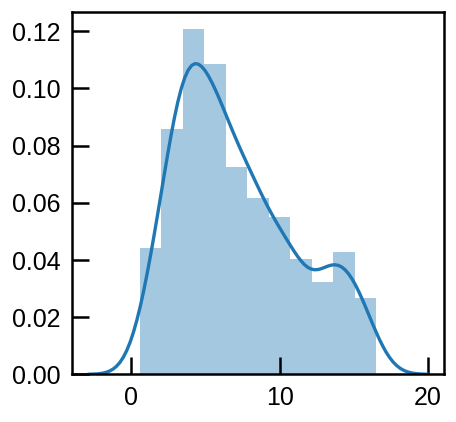

In [99]:
sns.distplot(dr)
dxarr = np.linspace(0, 10, 21)

In [65]:
# tmp = df_vanilla_dr2.loc[df_vanilla_dr2['radial_velocity'].notnull()].reset_index(drop=True)

In [66]:
df_vanilla_dr2= df_vanilla_dr2.drop(index=187).reset_index(drop=True)
df_vanilla_dr2= df_vanilla_dr2.drop(index=[34, 108, 151]).reset_index(drop=True)

In [72]:
df_vanilla_dr2 = df_vanilla_dr2.assign(
    vra_error=df_vanilla_dr2.g.vra_error,
    vdec_error=df_vanilla_dr2.g.vdec_error,
    inplace=True)

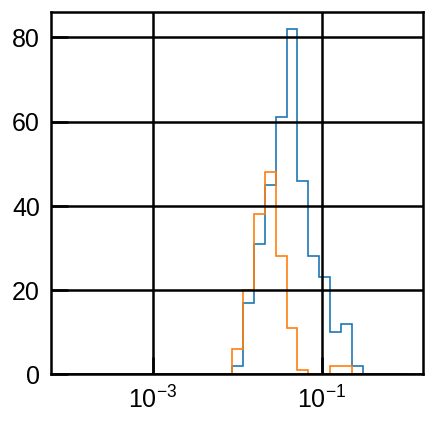

In [113]:
df_vanilla_dr2.groupby(df_vanilla_dr2["radial_velocity"].notnull())["vdec_error"].hist(
    bins=np.logspace(-4, 0, 32), histtype='step'
)
plt.gca().set_xscale('log');

In [75]:
%%time
m = kn.Fitter()
b0 = np.median(hy_dr2.g.icrs.cartesian.xyz.value, axis=1)
print(f"b0 = {b0}")

stanfit = m.fit(tmp, b0=b0)
azfit = az.from_pystan(stanfit)

INFO:kinesis.models:Reading model from disk


b0 = [17.26821532 41.64304963 13.606407  ]
CPU times: user 5.09 s, sys: 1.2 s, total: 6.28 s
Wall time: 2min


In [76]:
az.summary(azfit, var_names=['v0', 'sigv', 'T_param'])

,mean,sd,mcse_mean,mcse_sd,hpd_3%,hpd_97%,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
v0[0],-6.128,0.035,0.000,0.000,-6.194,-6.065,5538.0,5538.0,5510.0,3026.0,1.0
v0[1],45.691,0.042,0.001,0.000,45.613,45.769,5612.0,5612.0,5602.0,2853.0,1.0
v0[2],5.541,0.034,0.000,0.000,5.478,5.608,5506.0,5504.0,5501.0,2882.0,1.0
sigv,0.403,0.017,0.000,0.000,0.375,0.438,5519.0,5477.0,5553.0,3322.0,1.0
"T_param[0,0]",-14.807,11.041,0.170,0.131,-35.088,6.513,4216.0,3577.0,4218.0,3221.0,1.0
"T_param[0,1]",6.225,6.991,0.112,0.091,-6.991,19.229,3887.0,2922.0,3926.0,3006.0,1.0
"T_param[0,2]",3.521,8.855,0.136,0.128,-12.553,20.177,4255.0,2389.0,4267.0,3001.0,1.0
"T_param[1,0]",-16.960,14.388,0.218,0.181,-44.346,10.013,4353.0,3158.0,4371.0,3194.0,1.0
"T_param[1,1]",6.916,8.781,0.138,0.116,-8.781,23.446,4067.0,2862.0,4098.0,3113.0,1.0
"T_param[1,2]",11.108,11.454,0.184,0.145,-9.610,33.111,3866.0,3123.0,3855.0,3124.0,1.0


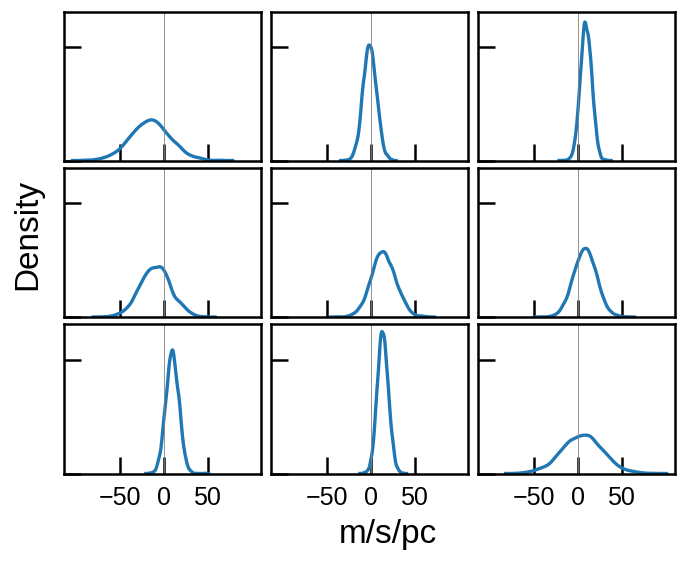

In [73]:
fig, ax = plt.subplots(3, 3, figsize=(6, 5), sharex=True, sharey=True)
fig.subplots_adjust(bottom=0.15, top=0.92, right=0.95, left=0.1, hspace=0.05, wspace=0.05)
ax = ax.ravel()
for cax, cT in zip(ax, stanfit['T_param'].reshape((-1, 9)).T):
#     cax.hist(cT, bins=32, density=True, histtype="step")
    sns.distplot(cT, hist=False, ax=cax)
    cax.axvline(0, c="gray", lw=0.5)
fig.text(0.55, 0.05, "m/s/pc", ha="center", va="center", size=20)
fig.text(0.05, 0.55, "Density", ha="center", va="center", rotation=90, size=20)
for cax in ax: cax.yaxis.set_major_formatter(ticker.NullFormatter())
for cax in ax: cax.set_xticks([-50, 0, 50])
# fig.suptitle("leao_dr2_harps_frcor $T$");
# fig.savefig("mock_posterior_T.png")

omega = 11.400932107253535 +- 5.368236808120433


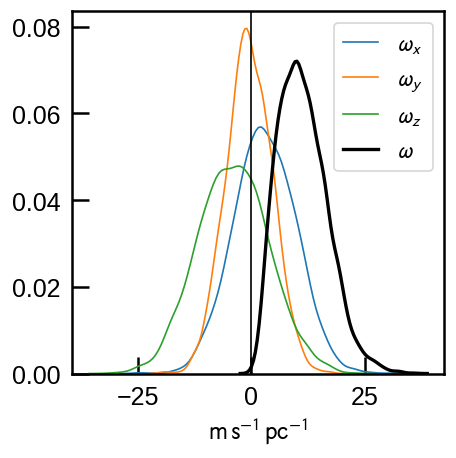

In [76]:
wT = decompose_T(stanfit["T_param"])
fig, ax = plt.subplots(figsize=(4,4))
sns.distplot(wT["omegax"], hist=False, kde_kws={'lw':1}, label=r'$\omega_x$')
sns.distplot(wT["omegay"], hist=False, kde_kws={'lw':1}, label=r'$\omega_y$')
sns.distplot(wT["omegaz"], hist=False, kde_kws={'lw':1}, label=r'$\omega_z$')
omega = np.sqrt(wT["omegax"] ** 2 + wT["omegay"] ** 2 + wT["omegaz"] ** 2)
print(f"omega = {np.mean(omega)} +- {np.std(omega)}")
sns.distplot(omega, hist=False, color='k', label=r'$\omega$')
ax.axvline(0, c='k', lw=1)
ax.legend(fontsize=14)
ax.set_xlabel(r'$\rm m\,\rm s^{-1}\,\rm pc^{-1}$');

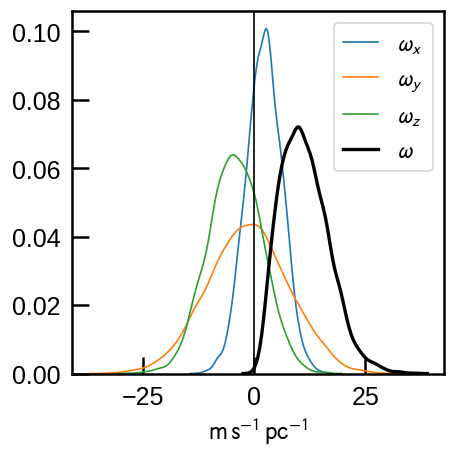

In [77]:
# hack rotation matrix from icrs -> galactic
rotmat = coord.ICRS(
    [1, 0, 0], [0, 1, 0], [0, 0, 1], representation_type=coord.CartesianRepresentation
).transform_to(coord.Galactic).cartesian.xyz.value

def rotate_T_to_galactic(T):
    """R T R^T"""
    rotated_T = np.einsum('ij,njk,kl->nil', rotmat, T, rotmat.T)
    return rotated_T

wT = decompose_T(rotate_T_to_galactic(stanfit["T_param"]))
fig, ax = plt.subplots(figsize=(4,4))
sns.distplot(wT["omegax"], hist=False, kde_kws={'lw':1}, label=r'$\omega_x$')
sns.distplot(wT["omegay"], hist=False, kde_kws={'lw':1}, label=r'$\omega_y$')
sns.distplot(wT["omegaz"], hist=False, kde_kws={'lw':1}, label=r'$\omega_z$')
omega = np.sqrt(wT["omegax"] ** 2 + wT["omegay"] ** 2 + wT["omegaz"] ** 2)
sns.distplot(omega, hist=False, color='k', label=r'$\omega$')
ax.axvline(0, c='k', lw=1)
ax.legend(fontsize=14)
ax.set_xlabel(r'$\rm m\,\rm s^{-1}\,\rm pc^{-1}$');

In [78]:
T_galactic = rotate_T_to_galactic(stanfit["T_param"])
# T_galactic = stanfit["T_param"]
T_sym = (T_galactic + np.transpose(T_galactic, (0, 2, 1))) / 2.
T_antisym = (T_galactic - np.transpose(T_galactic, (0, 2, 1))) / 2.

In [79]:
# math check
assert (
    (T_antisym[:, 2, 1] == decompose_T(T_galactic)["omegax"]).all(),
    (T_antisym[:, 0, 2] == decompose_T(T_galactic)["omegay"]).all(),
    (T_antisym[:, 1, 0] == decompose_T(T_galactic)["omegaz"]).all(),
) == (True, True, True)

In [80]:
w, v = np.linalg.eig(T_sym)

In [81]:
i_wsort = np.argsort(w, axis=1)
# my numpy-fu running out...
sorted_v = np.stack([v[j][:,i] for j, i in enumerate(i_wsort)])
sorted_w = np.sort(w, axis=1)

In [82]:
# verify math
assert np.allclose(sorted_w.mean(axis=1), decompose_T(T_galactic)["kappa"]) == True

In [83]:
plt.rc("figure", figsize=(4,4))

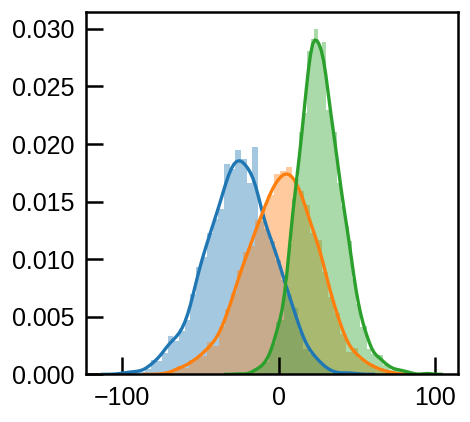

In [84]:
sns.distplot(sorted_w.T[0])
sns.distplot(sorted_w.T[1])
sns.distplot(sorted_w.T[2]);

In [57]:
np.nanmean(hy_dr2.g.galactic.velocity.d_z)

<Quantity -1.18647603 km / s>

In [54]:
hy_dr2.g.galactic.cartesian.xyz.mean(axis=1)

<Quantity [-44.44776064,   0.05072953, -16.78978432] pc>

In [8]:
(21*u.km/u.s/u.kpc).to(1./u.Myr)**2

<Quantity 0.00046126 1 / Myr2>

In [85]:
for cw in sorted_w.T:
    print(f"{np.mean(cw):8.3f} +- {np.std(cw):8.3f} ({np.abs(np.mean(cw)/np.std(cw)):8.3f})")

 -25.103 +-   21.738 (   1.155)
   2.044 +-   22.857 (   0.089)
  26.831 +-   14.532 (   1.846)


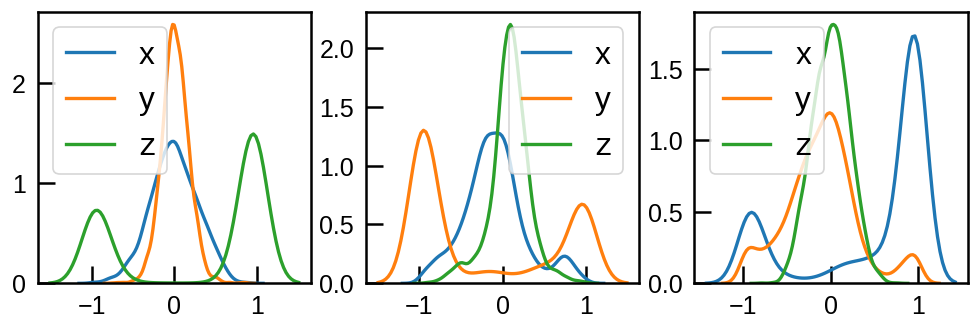

In [36]:
fig, ax = plt.subplots(1, 3, figsize=(10,3))
for i in range(3):
    vd = pd.DataFrame(sorted_v[:,:,i], columns=['x','y','z'])
    for col in vd:
        sns.kdeplot(vd[col], ax=ax[i])

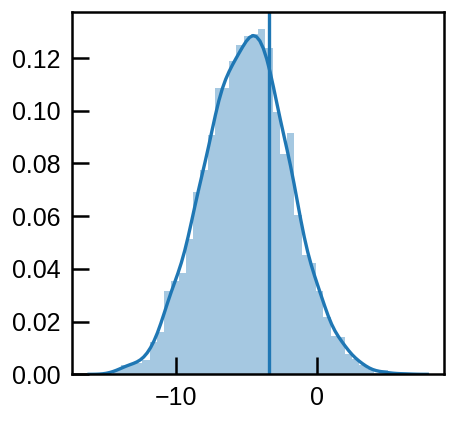

In [37]:
sns.distplot(T_galactic[:,1,0])
np.mean(T_galactic[:,1,0]), np.std(T_galactic[:,1,0])
plt.axvline(-3.4);

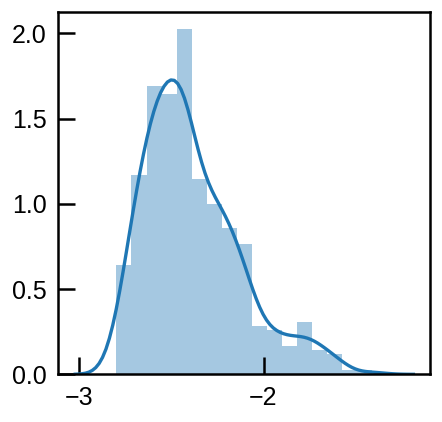

In [86]:
sns.distplot(np.log10(df_vanilla_dr2['parallax_error']/df_vanilla_dr2['parallax']))

In [82]:
df_vanilla_dr2 = df_vanilla_dr2.assign(
    icrs_x=df_vanilla_dr2.g.icrs.cartesian.x,
    icrs_y=df_vanilla_dr2.g.icrs.cartesian.y,
    icrs_z=df_vanilla_dr2.g.icrs.cartesian.z,
    gal_x=df_vanilla_dr2.g.galactic.cartesian.x,
    gal_y=df_vanilla_dr2.g.galactic.cartesian.y,
    gal_z=df_vanilla_dr2.g.galactic.cartesian.z,
)

In [97]:
x, y, z = df_vanilla_dr2.g.icrs.cartesian.xyz
dx, dy, dz = x-x.mean(), y-y.mean(), z-z.mean()
dr = np.sqrt(dx**2+dy**2+dz**2)

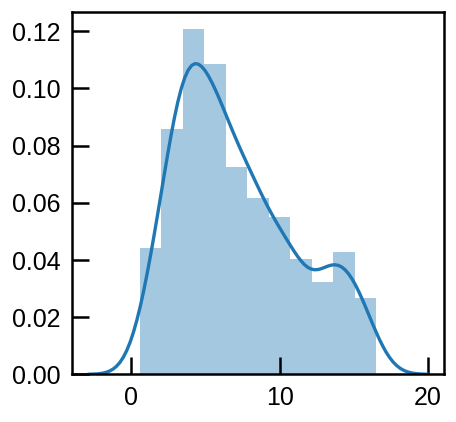

In [99]:
sns.distplot(dr)
dxarr = np.linspace(0, 10, 21)

In [108]:
df_vanilla_dr2[['gal_x', 'gal_y', 'gal_z']].describe()

,gal_x,gal_y,gal_z
count,515.000000,515.000000,515.000000
mean,-44.447761,0.050730,-16.789784
std,5.914090,4.623677,3.273785
min,-60.707233,-13.764624,-30.160668
25%,-47.632088,-2.747963,-19.064730
50%,-43.716060,0.153145,-16.992104
75%,-41.098669,2.990003,-14.624051
max,-29.199746,16.065538,-7.241971


In [111]:
tmp = df_vanilla_dr2[['gal_x', 'gal_y', 'gal_z']]

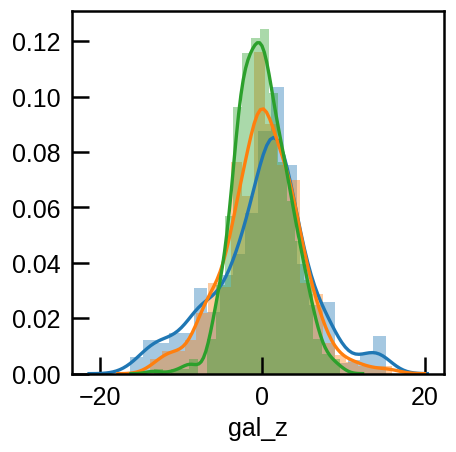

In [115]:
tmp.apply(lambda x: sns.distplot(x-np.mean(x)), axis=0);

ValueError: color kwarg must have one color per data set. 3 data sets and 1 colors were provided

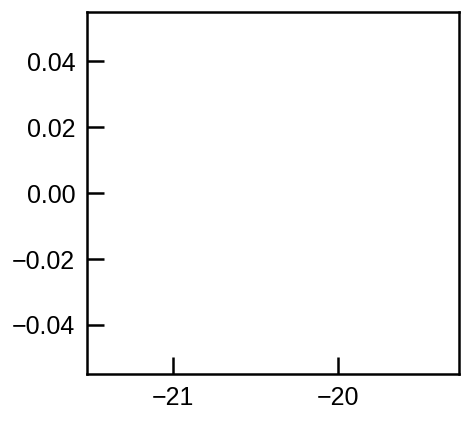

In [110]:
sns.distplot(df_vanilla_dr2[gal])

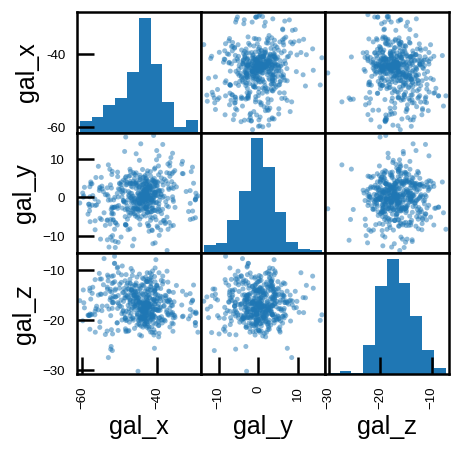

In [107]:
pd.plotting.scatter_matrix(df_vanilla_dr2[['gal_x', 'gal_y', 'gal_z']]);

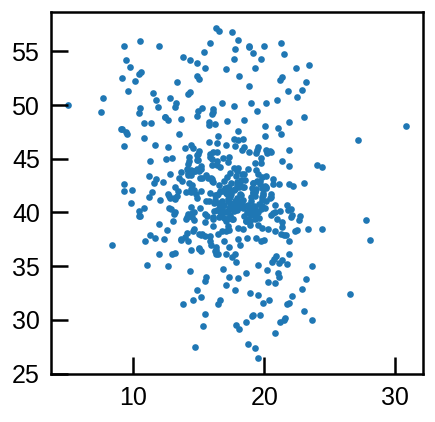

In [89]:
plt.scatter(df_vanilla_dr2.g.icrs.cartesian.x, df_vanilla_dr2.g.icrs.cartesian.y, s=9)

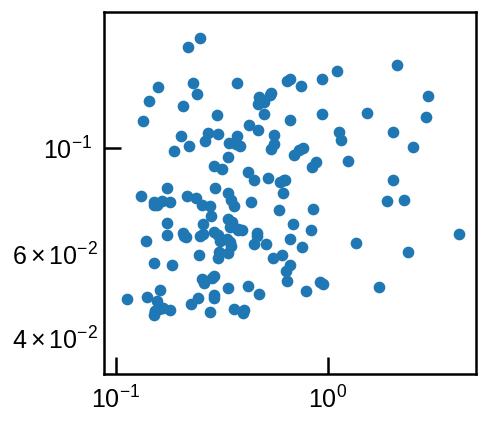

In [23]:
plt.scatter(stanfit.data['rv_error'], stanfit['rv_model'].std(axis=0))
plt.xscale('log')
plt.yscale('log');
x=np.logspace(-1,2)
# plt.plot(x, x, 'k-');

In [96]:
delta_rv = (stanfit.data['rv'][None,:] - stanfit['rv_model']) / np.hypot(stanfit.data['rv_error'][None,:], stanfit['sigv'][:,None])
delta_rv1 = (stanfit.data['rv'][None,:] - stanfit['rv_model']) / stanfit.data['rv_error'][None,:]
delta_rv2 = (stanfit.data['rv'][None,:] - stanfit['rv_model'])

In [97]:
mean_delta_rv = np.mean(delta_rv, axis=0)
std_delta_rv = np.std(delta_rv, axis=0)

In [98]:
import scipy as sp

In [99]:
df_vanilla_dr2.loc[(mean_delta_rv>3)]

,ra,dec,phot_g_mean_mag,parallax,pmra,pmdec,parallax_error,pmra_error,pmdec_error,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,radial_velocity,radial_velocity_error,vra_error,vdec_error,inplace
34,68.189623,12.066609,13.763806,20.549995,96.952515,-14.186060,0.056649,0.105020,0.069763,0.289357,0.340846,-0.143548,NaN,NaN,0.066241,0.018449,True
107,62.776044,18.928968,14.218579,19.731306,109.682796,-28.682527,0.083520,0.145464,0.106822,0.285022,0.224602,0.270783,NaN,NaN,0.116889,0.038852,True
150,59.809805,22.043668,12.076345,24.631610,148.483728,-43.928374,0.050212,0.093806,0.059589,0.095349,-0.128552,0.333687,34.406036,0.317873,0.060987,0.020701,True


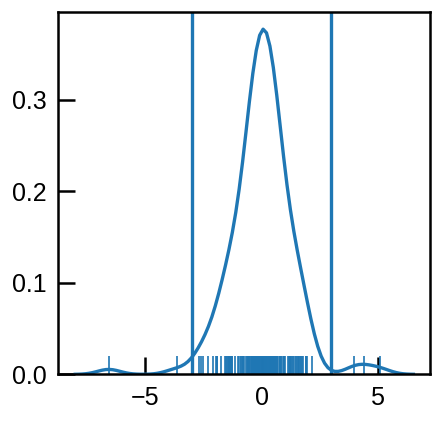

In [100]:
sns.distplot(mean_delta_rv, hist=False, rug=True);
# plt.plot(x, px, 'k-');
plt.axvline(-3)
plt.axvline(3);

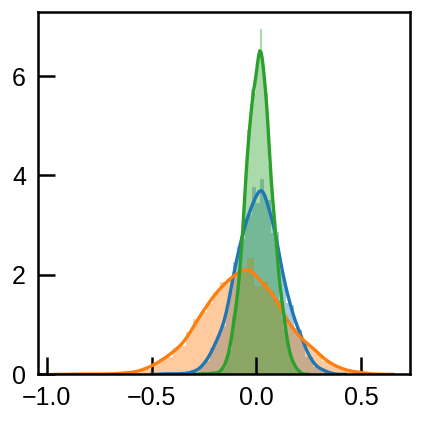

In [101]:
sns.distplot(delta_rv.mean(axis=1))
sns.distplot(delta_rv1.mean(axis=1));
sns.distplot(delta_rv2.mean(axis=1));

In [339]:
stanfit.data['irv'][stanfit.data['rv'].argsort()[0]]

187

In [355]:
hy_dr2['ruwe'][187]

1.2597213587987073

In [340]:
df_vanilla_dr2.iloc[187]

ra                       78.714192
dec                      17.787029
phot_g_mean_mag          13.499721
parallax                 17.602923
pmra                     54.276757
pmdec                   -27.363508
parallax_error            0.053941
pmra_error                0.081767
pmdec_error               0.062659
parallax_pmra_corr        0.306982
parallax_pmdec_corr       0.412306
pmra_pmdec_corr           0.060959
radial_velocity          16.515485
radial_velocity_error     2.967589
Name: 187, dtype: float64

In [44]:
hy_dr2 = gp.add_ruwe(hy_dr2)
hy_dr2 = hy_dr2.assign(
    icrs_vx=hy_dr2.g.icrs.velocity.d_x,
    icrs_vy=hy_dr2.g.icrs.velocity.d_y,
    icrs_vz=hy_dr2.g.icrs.velocity.d_z,
)

In [43]:
np.median(stanfit.data['rv_error'])

0.3576707490845559

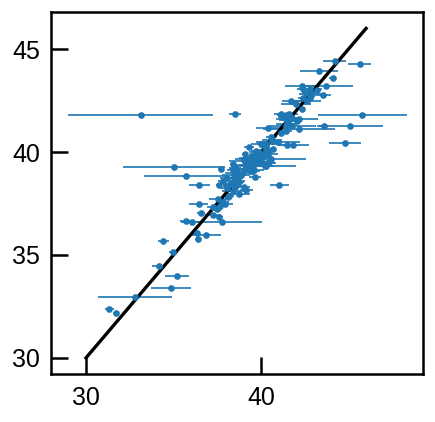

In [86]:
plt.errorbar(stanfit.data['rv'], stanfit['rv_model'].mean(axis=0), xerr=stanfit.data['rv_error'], ls='None', marker='.', elinewidth=1);
x = np.linspace(30,46)
plt.plot(x,x, c='k')

In [42]:
plt.errorbar(np.arange(len(mean_delta_rv)), mean_delta_rv, yerr=std_delta_rv, marker='.', ls='None');

NameError: name 'mean_delta_rv' is not defined

In [267]:
D = stanfit.data['C'].copy()
D[:,1, 1] += stanfit['sigv']**2 / stanfit['d']

(515, 3, 3)

In [266]:
delta = stanfit.data['a'][None,:,:] - stanfit['a_model']


(515, 3)

In [265]:
stan
stanfit['a_model']

(4000, 515, 3)

In [70]:
w

array([ 29.91438517, -34.74085269, -11.59109153])

In [71]:
v

array([[ 0.96295271, -0.201319  , -0.17942336],
       [-0.21827389, -0.19115022, -0.95698386],
       [-0.15836222, -0.96069363,  0.2280113 ]])

In [37]:
asser

array([ -3.13993333,   9.42527047,  -4.21650099, ...,  -7.10194253,
       -10.08935932,   4.42523089])

In [264]:
# results will be saved here
stanfit = {}
azfit = {}

# potential hessians

In [102]:
from gala.potential import MilkyWayPotential
pot = MilkyWayPotential(halo=dict(c=1.)) # make it spherical


In [104]:
xgc = df_rvcleaned_dr2_2.g.icrs.transform_to(coord.Galactocentric)

In [111]:
hess = pot.hessian(xgc.cartesian.xyz.mean(axis=1).to(u.kpc))[:,:,0]

In [119]:
hess_kmskpc = np.sign(hess) * np.sqrt(np.abs(hess)).to(u.km/u.s/u.kpc).value

In [120]:
hess_kmskpc

array([[-23.94081491,   0.77446557,   4.07574329],
       [  0.77446557,  11.35634417,  -0.11912428],
       [  4.07574329,  -0.11912428,  66.85690567]])

In [121]:
w, v = np.linalg.eig(hess_kmskpc)

In [122]:
w

array([-24.14049698,  67.03961894,  11.37331298])

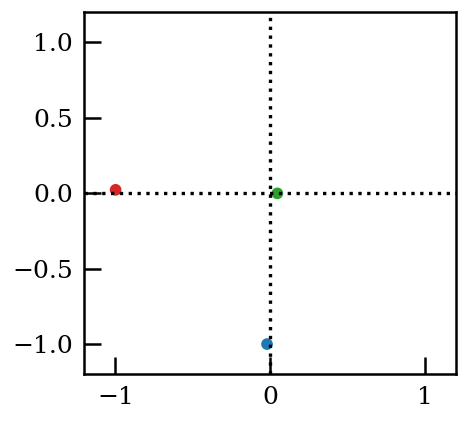

In [128]:
plt.scatter(v[0], v[1], c=['tab:red', 'tab:green', 'tab:blue'])
plt.axis([-1.2,1.2,-1.2,1.2])
plt.axvline(0, c='k', ls=':')
plt.axhline(0, c='k', ls=':');

In [28]:
pot.hessian([0, 8., 0] * u.kpc)

<Quantity [[[ 0.00044584],
            [ 0.        ],
            [ 0.        ]],

           [[ 0.        ],
            [-0.00072027],
            [ 0.        ]],

           [[ 0.        ],
            [ 0.        ],
            [ 0.00551634]]] 1 / Myr2>

In [29]:
pot.hessian([8, 0., 0] * u.kpc)

<Quantity [[[-0.00072027],
            [ 0.        ],
            [ 0.        ]],

           [[ 0.        ],
            [ 0.00044584],
            [ 0.        ]],

           [[ 0.        ],
            [ 0.        ],
            [ 0.00551634]]] 1 / Myr2>

In [47]:
hess = pot.hessian([8,0, 0] * u.kpc)

In [48]:
hess

<Quantity [[[-0.00072027],
            [ 0.        ],
            [ 0.        ]],

           [[ 0.        ],
            [ 0.00044584],
            [ 0.        ]],

           [[ 0.        ],
            [ 0.        ],
            [ 0.00551634]]] 1 / Myr2>

In [45]:
hy_dr2.g.galactic.cartesian.z.mean()

<Quantity -16.78978432 pc>

In [46]:
nz = hess.ravel()[hess.ravel() != 0]
(np.sign(nz) * np.sqrt(np.abs(nz))).to(u.km/u.s/u.kpc)

<Quantity [-26.24192665,  20.646093  ,  72.62261898] km / (kpc s)>

In [49]:
72.6/26.2

2.7709923664122136

## Fit: Leao DR2 + HARPS RV + frame rotation correction

In [265]:
%%time
m = kn.Fitter()
b0 = np.median(df['leao_dr2_harps'].g.icrs.cartesian.xyz.value, axis=1)

for k, d in df.items():
    stanfit[k] = m.fit(df[k], b0=b0)

INFO:kinesis.models:Reading model from disk


CPU times: user 4.16 s, sys: 3.09 s, total: 7.25 s
Wall time: 1min 53s


In [266]:
for k, v in stanfit.items():
    azfit[k] = az.from_pystan(v)

In [269]:
azfit.keys()

dict_keys(['leao_dr2_harps', 'leao_dr2_harps_frcor'])

In [318]:
(20*u.m/u.s/u.pc).to(u.mas/u.yr, equivalencies=u.equivalencies.dimensionless_angles())

<Quantity 4.21899053 mas / yr>

In [316]:
((u.m/u.pc).decompose() * (u.yr/u.s).decompose() * u.rad.to(u.mas)).decompose()

<Quantity 0.21094953>

In [328]:
az.summary(azfit['leao_dr2_harps'], var_names=['v0', 'sigv'])

,mean,sd,mcse_mean,mcse_sd,hpd_3%,hpd_97%,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
v0[0],-6.118,0.041,0.001,0.0,-6.193,-6.039,3779.0,3779.0,3787.0,2825.0,1.0
v0[1],45.792,0.042,0.001,0.0,45.710,45.870,3703.0,3703.0,3690.0,2531.0,1.0
v0[2],5.597,0.041,0.001,0.0,5.521,5.674,3692.0,3689.0,3699.0,2473.0,1.0
sigv,0.321,0.018,0.000,0.0,0.288,0.355,3764.0,3758.0,3733.0,2835.0,1.0


In [329]:
az.summary(azfit['leao_dr2_harps_frcor'], var_names=['v0', 'sigv'])

,mean,sd,mcse_mean,mcse_sd,hpd_3%,hpd_97%,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
v0[0],-6.119,0.042,0.001,0.0,-6.201,-6.043,4266.0,4262.0,4230.0,3016.0,1.0
v0[1],45.792,0.041,0.001,0.0,45.713,45.868,4657.0,4657.0,4676.0,3056.0,1.0
v0[2],5.602,0.042,0.001,0.0,5.520,5.680,4600.0,4600.0,4591.0,2736.0,1.0
sigv,0.320,0.018,0.000,0.0,0.289,0.356,3998.0,3975.0,3977.0,2434.0,1.0


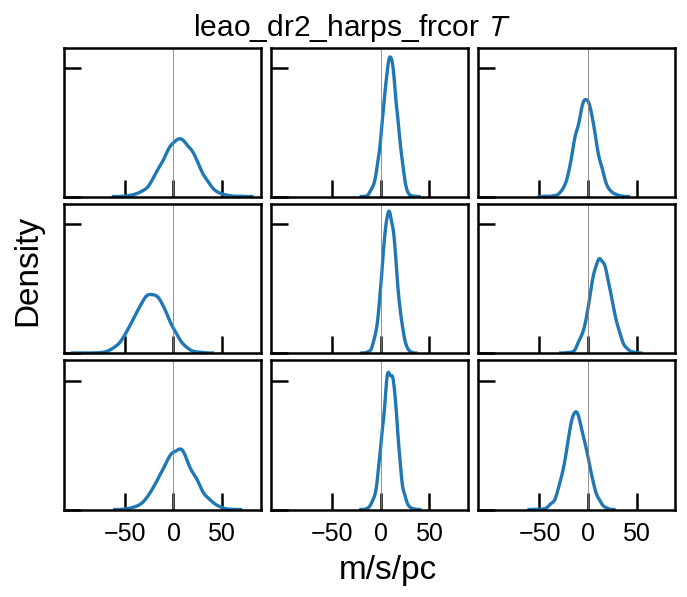

In [360]:
fig, ax = plt.subplots(3, 3, figsize=(6, 5), sharex=True, sharey=True)
fig.subplots_adjust(bottom=0.15, top=0.92, right=0.95, left=0.1, hspace=0.05, wspace=0.05)
ax = ax.ravel()
for cax, cT in zip(ax, stanfit['leao_dr2_harps_frcor']['T_param'].reshape((-1, 9)).T):
#     cax.hist(cT, bins=32, density=True, histtype="step")
    sns.distplot(cT, hist=False, ax=cax)
    cax.axvline(0, c="gray", lw=0.5)
fig.text(0.55, 0.05, "m/s/pc", ha="center", va="center", size=20)
fig.text(0.05, 0.55, "Density", ha="center", va="center", rotation=90, size=20)
for cax in ax: cax.yaxis.set_major_formatter(ticker.NullFormatter())
for cax in ax: cax.set_xticks([-50, 0, 50])
fig.suptitle("leao_dr2_harps_frcor $T$");
# fig.savefig("mock_posterior_T.png")

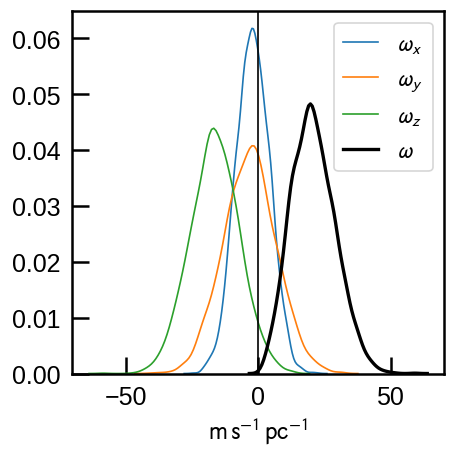

In [376]:
wT = decompose_T(stanfit["leao_dr2_harps_frcor"]["T_param"])
fig, ax = plt.subplots()
sns.distplot(wT["omegax"], hist=False, kde_kws={'lw':1}, label=r'$\omega_x$')
sns.distplot(wT["omegay"], hist=False, kde_kws={'lw':1}, label=r'$\omega_y$')
sns.distplot(wT["omegaz"], hist=False, kde_kws={'lw':1}, label=r'$\omega_z$')
omega = np.sqrt(wT["omegax"] ** 2 + wT["omegay"] ** 2 + wT["omegaz"] ** 2)
sns.distplot(omega, hist=False, color='k', label=r'$\omega$')
ax.axvline(0, c='k', lw=1)
ax.legend(fontsize=14)
ax.set_xlabel(r'$\rm m\,\rm s^{-1}\,\rm pc^{-1}$');

In [209]:
# hack rotation matrix from icrs -> galactic
coord.ICRS(
    1,0,0, representation_type=coord.CartesianRepresentation
).transform_to(coord.Galactic).cartesian.xyz.value

array([-0.05487566,  0.49410944, -0.86766614])

In [378]:
# hack rotation matrix from icrs -> galactic
rotmat = coord.ICRS(
    [1, 0, 0], [0, 1, 0], [0, 0, 1], representation_type=coord.CartesianRepresentation
).transform_to(coord.Galactic).cartesian.xyz.value

def rotate_T_to_galactic(T):
    """R T R^T"""
    rotated_T = np.einsum('ij,njk,kl->nil', rotmat, T, rotmat.T)
    return rotated_T

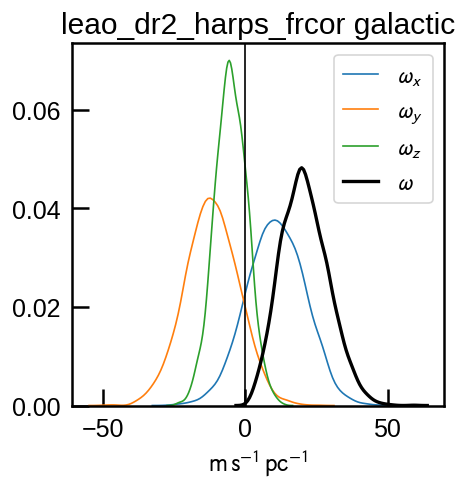

In [381]:
wT = decompose_T(rotate_T_to_galactic(stanfit["leao_dr2_harps_frcor"]["T_param"]))
fig, ax = plt.subplots()
sns.distplot(wT["omegax"], hist=False, kde_kws={'lw':1}, label=r'$\omega_x$')
sns.distplot(wT["omegay"], hist=False, kde_kws={'lw':1}, label=r'$\omega_y$')
sns.distplot(wT["omegaz"], hist=False, kde_kws={'lw':1}, label=r'$\omega_z$')
omega = np.sqrt(wT["omegax"] ** 2 + wT["omegay"] ** 2 + wT["omegaz"] ** 2)
sns.distplot(omega, hist=False, color='k', label=r'$\omega$')
ax.axvline(0, c='k', lw=1)
ax.legend(fontsize=14)
ax.set_xlabel(r'$\rm m\,\rm s^{-1}\,\rm pc^{-1}$');
ax.set_title("leao_dr2_harps_frcor galactic");

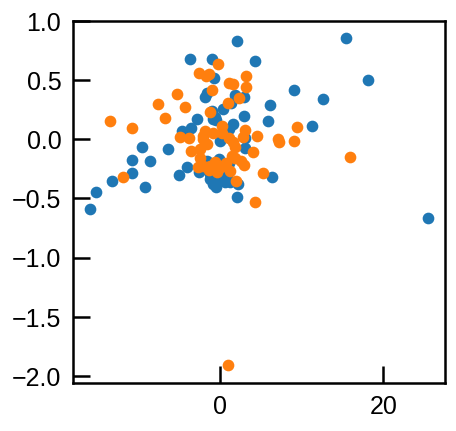

In [243]:
plt.scatter(
    df_leao_gaia_harps.g.galactic.cartesian.x
    - df_leao_gaia_harps.g.galactic.cartesian.x.mean(),
    df_leao_gaia_harps.g.galactic.velocity.d_x
    - df_leao_gaia_harps.g.galactic.velocity.d_x.mean(),
)
plt.scatter(
    df_leao_gaia_harps.g.galactic.cartesian.y
    - df_leao_gaia_harps.g.galactic.cartesian.y.mean(),
    df_leao_gaia_harps.g.galactic.velocity.d_y
    - df_leao_gaia_harps.g.galactic.velocity.d_y.mean(),
)

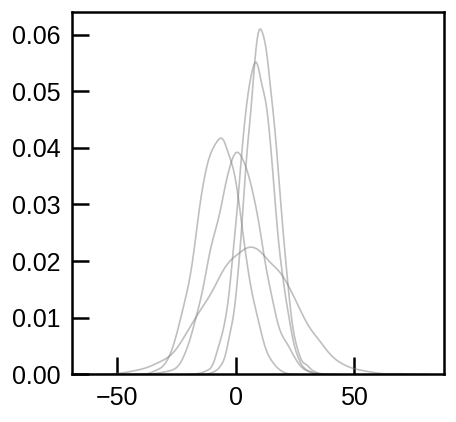

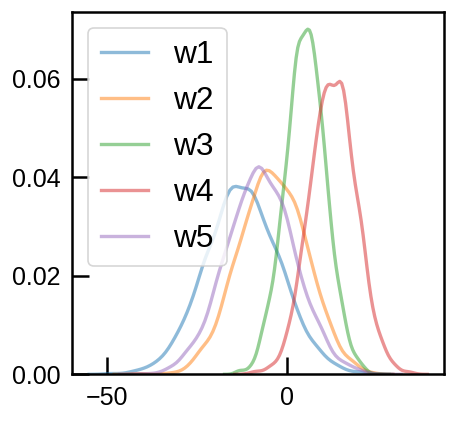

In [408]:
wT = decompose_T(stanfit["leao_dr2_harps_frcor"]["T_param"])
for key in ['w1','w2','w3','w4','w5']:
    sns.distplot(wT[key], hist=False, color='gray', kde_kws={'alpha':.5, 'lw':1})
plt.figure()
wT = decompose_T(rotate_T_to_galactic(stanfit["leao_dr2_harps_frcor"]["T_param"]))
for key in ['w1','w2','w3','w4','w5']:
    sns.distplot(wT[key], hist=False, kde_kws={'alpha':.5, 'lw':2}, label=key)
# sns.distplot(wT['w1'], hist=False,);
plt.legend()

In [123]:
# %%time
# stanfit_repeat = [m.fit(df, b0=b0) for i in range(5)]

CPU times: user 11.2 s, sys: 8.52 s, total: 19.7 s
Wall time: 5min 49s


### Fit Leao HARPS incl. one obvious outlier

In [392]:
%%time
b0 = np.median(df['leao_dr2_harps'].g.icrs.cartesian.xyz.value, axis=1)
stanfit['leao_incl_outlier'] = m.fit(df['leao_incl_outlier'], b0=b0)

CPU times: user 2.08 s, sys: 1.86 s, total: 3.94 s
Wall time: 57.4 s


In [394]:
azfit['leao_incl_outlier'] = az.from_pystan(stanfit['leao_incl_outlier'])

In [396]:
az.summary(azfit['leao_incl_outlier'], var_names=['v0', 'sigv'])

,mean,sd,mcse_mean,mcse_sd,hpd_3%,hpd_97%,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
v0[0],-6.150,0.081,0.001,0.001,-6.293,-5.991,3273.0,3273.0,3285.0,2664.0,1.0
v0[1],45.818,0.080,0.001,0.001,45.662,45.958,2958.0,2958.0,2957.0,2533.0,1.0
v0[2],5.561,0.081,0.001,0.001,5.412,5.710,3848.0,3848.0,3852.0,2709.0,1.0
sigv,0.620,0.035,0.001,0.000,0.555,0.686,2726.0,2695.0,2770.0,2175.0,1.0
"T_param[0,0]",76.520,31.930,0.608,0.430,17.469,137.502,2756.0,2756.0,2759.0,2685.0,1.0
"T_param[0,1]",29.450,13.391,0.250,0.179,5.443,56.016,2863.0,2793.0,2866.0,2690.0,1.0
"T_param[0,2]",-46.145,19.527,0.338,0.245,-81.519,-8.386,3331.0,3184.0,3331.0,3009.0,1.0
"T_param[1,0]",-80.188,30.799,0.601,0.425,-140.132,-24.872,2629.0,2629.0,2627.0,2869.0,1.0
"T_param[1,1]",-7.405,13.452,0.252,0.194,-32.201,18.424,2851.0,2394.0,2840.0,2663.0,1.0
"T_param[1,2]",48.056,19.031,0.336,0.244,11.585,82.693,3217.0,3051.0,3212.0,3040.0,1.0
